In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import itertools
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from google.colab import drive
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from numpy import asarray
from sklearn import preprocessing
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

In [ ]:
#Reading the data
drive.mount('/content/drive/')
cal_data = pd.read_csv('/content/drive/MyDrive/dataset2/calendar.csv')
salestv_data = pd.read_csv('/content/drive/MyDrive/dataset2/tableau_sales_train_validation_365_days.csv')
ss_data = pd.read_csv('/content/drive/MyDrive/dataset2/sample_submission.csv')
saleste_data = pd.read_csv('/content/drive/MyDrive/dataset2/tableau_sales_train_evaluation_365_days.csv')
sellp_data = pd.read_csv('/content/drive/MyDrive/dataset2/sell_prices.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
salestv_data.shape

(30490, 371)

In [ ]:
salestv_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,1,8,1,3,0,1,2,3
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


##Observation: We have sales for 365 days.

In [ ]:
cal_data.shape

(1969, 14)

In [ ]:
cal_data.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


##Observation: There are many entries which contain NaN in event_type_1,event_type_2,event_name_1 & enent_name_2

In [ ]:
ss_data.tail()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60979,FOODS_3_827_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
saleste_data.shape

(30490, 371)

##OBSERVATION: Here we have data for 371 columns. We will use this dataframe for testing.

In [ ]:
print(salestv_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 371 entries, id to d_365
dtypes: int64(365), object(6)
memory usage: 86.3+ MB
None


#Downcasting

In [ ]:
# To reduce memory usage
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype in ['int32', 'int64']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [ ]:
salestv_data_downcast = downcast_dtypes(salestv_data)

In [ ]:
print(salestv_data_downcast.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 371 entries, id to d_365
dtypes: int16(365), object(6)
memory usage: 22.6+ MB
None


In [ ]:
salestv_data_downcast.shape
salestv_data_downcast.head(8)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,1,8,1,3,0,1,2,3
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,7,4,20,26,0,9,14,0,8,18


In [ ]:
salestv_data = salestv_data_downcast

##Handling missing values through imputation

In [ ]:
#Clearly in calender.csv we have many entries which contain NaN in event_type_1,event_type_2,event_name_1 & enent_name_2
#replaced all those entries with no_event
cal_data = cal_data.fillna(value='no_event')

In [ ]:
cal_data.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,no_event,no_event,no_event,no_event,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,no_event,no_event,no_event,no_event,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,no_event,no_event,no_event,no_event,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,no_event,no_event,no_event,no_event,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,no_event,no_event,no_event,no_event,1,0,1


In [ ]:
cal_data.shape

(1969, 14)

#Optimizing the dataframes

##Making a final dataset which contains all the necessary values in one table.

##First, we start of by changing most of the columns with string type data to categorical dtype as almost all the columns are categories in this dataset.

In [ ]:
salestv_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,1,8,1,3,0,1,2,3
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
salestv_data = salestv_data.reset_index() 

In [ ]:
salestv_data.head()

,index,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,...,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365
0,0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,...,0,1,1,8,1,3,0,1,2,3
4,4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
l=[]
for i in range(1,366):
  l.append("d_"+str(i))
df_final=pd.melt(salestv_data,id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],\
                 value_vars=l,var_name="d",value_name="sales")

In [ ]:
df_final

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...,...
11128845,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_365,0
11128846,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_365,0
11128847,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_365,1
11128848,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_365,0


In [ ]:
df_final.drop(df_final[df_final['sales'] == 0].index, inplace = True)

In [ ]:
#taking only last 10 data days of test 
for i in range(355,366):
  l.append("d_"+str(i))
df_final_test=pd.melt(saleste_data,id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],\
                 value_vars=l,var_name="d",value_name="sales")

In [ ]:
for i in range(366,377):
    saleste_data['d_'+str(i)]=0

In [ ]:
#Also create future data to be used for futures sales data
l=[]
for i in range(366,377):
    l.append("d_"+str(i))
df_future_data=pd.melt(saleste_data,id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],\
                 value_vars=l,var_name="d",value_name="sales")    

In [ ]:
#Now we merge all these 3 dataframes to get final csv file train
data=df_final.merge(cal_data,on='d',copy=False)# combine calender.csv and modified trainvalidation.csv on feature 'd'
data=data.merge(sellp_data,on=["store_id", "item_id", "wm_yr_wk"],copy=False) # combine new dataframe with sell_price.csv usnig features "store_id", "item_id", "wm_yr_wk"
data.drop(data[data['sales'] == 0].index, inplace = True)
#storing this final dataframe to final_dataframe.csv
data.to_csv('final_dataframe.csv')

In [ ]:
data.shape

(2487327, 22)

In [ ]:
#Now we merge all these 3 dataframes to get final csv file test
data_test=df_final_test.merge(cal_data,on='d',copy=False) #combine calender.csv and modified trainevaluation.csv on feature 'd'
data_test=data_test.merge(sellp_data,on=["store_id", "item_id", "wm_yr_wk"],copy=False) # combine new dataframe with sell_price.csv usnig features "store_id", "item_id", "wm_yr_wk"
data_test.drop(data_test[data_test['sales'] == 0].index, inplace = True)
#storing this final dataframe to final_dataframe.csv
data_test.to_csv('final_dataframe_test.csv')

In [ ]:
print("Shape of final dataframe train is =",data.shape)
print("Shape of final dataframe test is =",data_test.shape)

Shape of final dataframe train is = (2487327, 22)
Shape of final dataframe test is = (2487327, 22)


In [ ]:
#reading up complete dataframe
data = pd.read_csv('final_dataframe.csv')
data_test = pd.read_csv('final_dataframe_test.csv')

In [ ]:
data.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
data_features = data.copy()

#Exploring various properties of DataFrame

In [ ]:
print("Head rows of Final DataFrame train")
data.head()

Head rows of Final DataFrame train


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.46000
1,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_2,15,2011-01-30,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.46000
2,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_6,4,2011-02-03,11101,...,2,2011,no_event,no_event,no_event,no_event,1,1,1,0.46000
3,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_7,6,2011-02-04,11101,...,2,2011,no_event,no_event,no_event,no_event,1,0,0,0.46000
4,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,1.56000


In [ ]:
print("Colums present in dataFrame are",data.columns.values)

Colums present in dataFrame are ['id' 'item_id' 'dept_id' 'cat_id' 'store_id' 'state_id' 'd' 'sales'
 'date' 'wm_yr_wk' 'weekday' 'wday' 'month' 'year' 'event_name_1'
 'event_type_1' 'event_name_2' 'event_type_2' 'snap_CA' 'snap_TX'
 'snap_WI' 'sell_price']


In [ ]:
print("Complete information about data Frame is:-\n")
print(data.info())

Complete information about data Frame is:-

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2487327 entries, 0 to 2487326
Data columns (total 22 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   item_id       object 
 2   dept_id       object 
 3   cat_id        object 
 4   store_id      object 
 5   state_id      object 
 6   d             object 
 7   sales         int64  
 8   date          object 
 9   wm_yr_wk      int64  
 10  weekday       object 
 11  wday          int64  
 12  month         int64  
 13  year          int64  
 14  event_name_1  object 
 15  event_type_1  object 
 16  event_name_2  object 
 17  event_type_2  object 
 18  snap_CA       int64  
 19  snap_TX       int64  
 20  snap_WI       int64  
 21  sell_price    float64
dtypes: float64(1), int64(8), object(13)
memory usage: 417.5+ MB
None


####Clearly this data frame is using a lot memory (991.0+ MB) so we will try to remove unnecessary features while doing Feature Engineering

In [ ]:
print("There are these unique stores in this data=",data['store_id'].unique())

There are these unique stores in this data= ['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']


In [ ]:
print("There are these sates in data=",data['state_id'].unique())

There are these sates in data= ['CA' 'TX' 'WI']


In [ ]:
print("Unique values of wday features=",data['wday'].unique())
print("Unique values of weekday features=",data['weekday'].unique())

Unique values of wday features= [1 2 6 7 3 4 5]
Unique values of weekday features= ['Saturday' 'Sunday' 'Thursday' 'Friday' 'Monday' 'Tuesday' 'Wednesday']


##From this it is inferred that 1 in wday corresponds to Saturday in weekday, 2 for Sunday and so on.

In [ ]:
print("years for which I have this sales data =",data['year'].unique())

years for which I have this sales data = [2011 2012]


#Exploratory Data Analysis

##Some Bar Plots of Pie Charts of sales

##A. Bargraph for Average sales for each category & Pie chart showing percentage of sales for each category

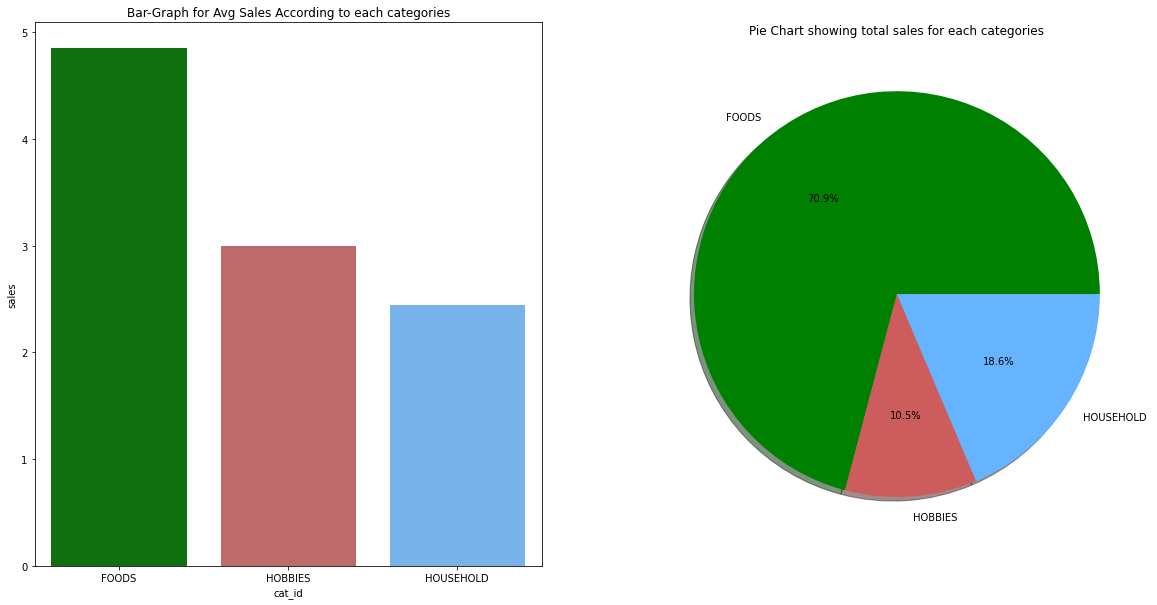

In [ ]:
df=data.groupby('cat_id').mean()
df.reset_index(level=0,inplace=True)
colors= ["green" ,"indianred", "#66b3ff"]
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='cat_id',y='sales',data=df,palette=colors)
plt.title("Bar-Graph for Avg Sales According to each categories")

plt.subplot(122)
df=data.groupby('cat_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['sales']/sum(df['sales'].values)*100
plt.pie(df['perc'].values,labels=df['cat_id'].values,shadow=True,autopct='%1.1f%%',colors=colors)
plt.title("Pie Chart showing total sales for each categories")
plt.show()

##OBSERVATION: Average and total sales for FOODS type is maximum

##B. Bargraph for Average sales for each State & Pie chart showing percentage of sales for each State


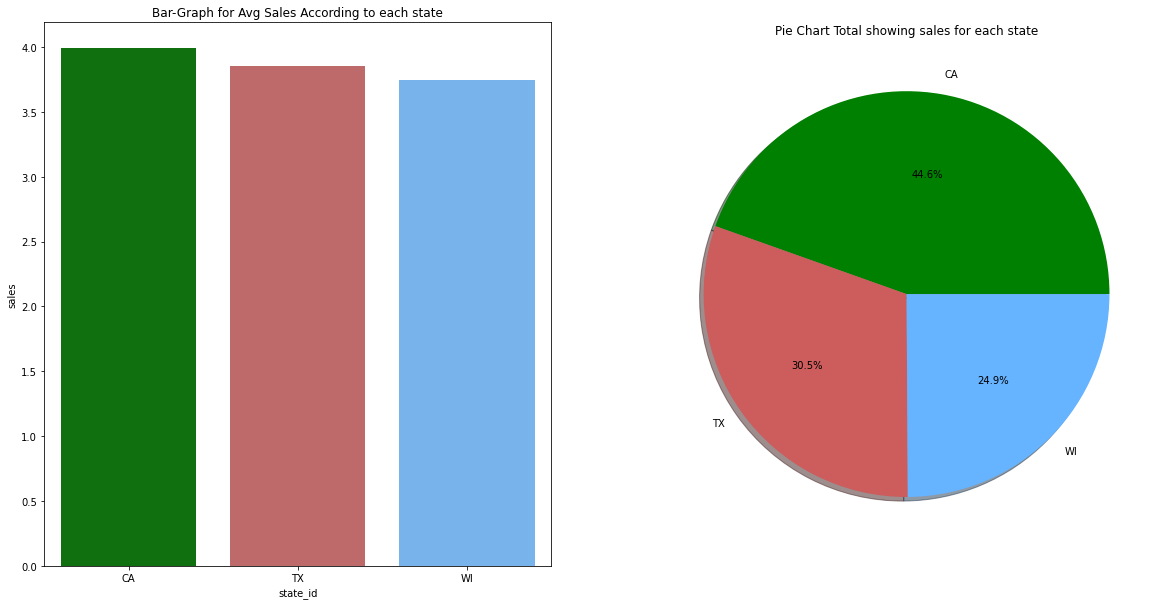

In [ ]:
df=data.groupby('state_id').mean()
df.reset_index(level=0,inplace=True)
colors= ["green" ,"indianred", "#66b3ff"]
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='state_id',y='sales',data=df,palette=colors)
plt.title("Bar-Graph for Avg Sales According to each state")

df=data.groupby('state_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['sales']/sum(df['sales'].values)*100

plt.subplot(122)
plt.pie(df['perc'].values,labels=df['state_id'].values,shadow=True,autopct='%1.1f%%',colors=colors)
plt.title("Pie Chart Total showing sales for each state")
plt.show()

##C. Bargraph for Average sales for each Store & Pie chart showing percentage of sales for each Store

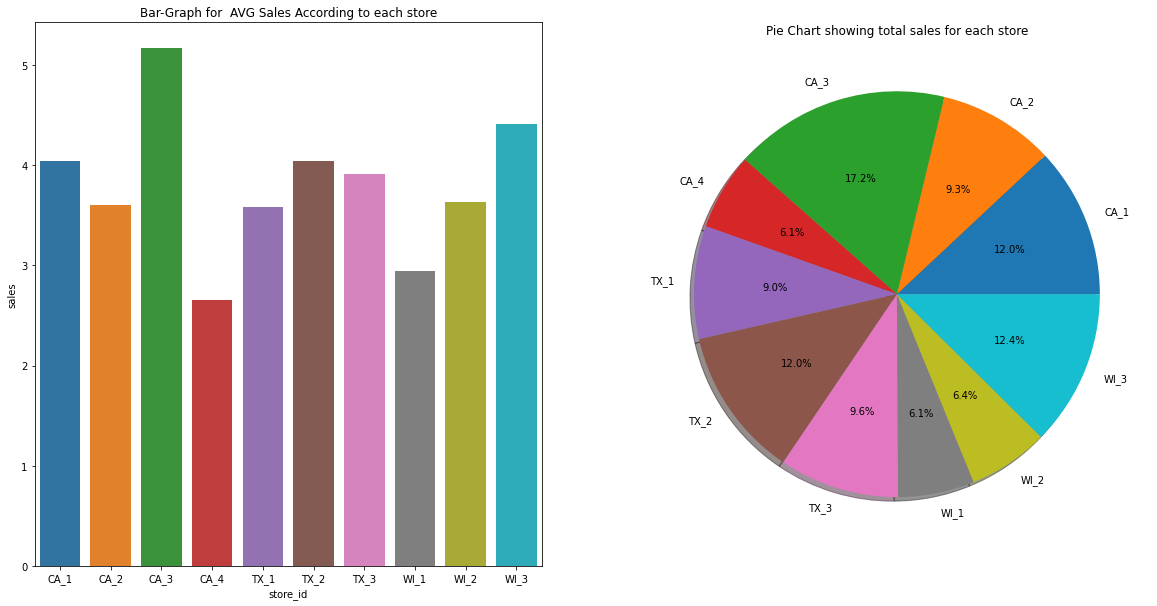

In [ ]:
df=data.groupby('store_id').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='store_id',y='sales',data=df)
plt.title("Bar-Graph for  AVG Sales According to each store")
df=data.groupby('store_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['sales']/sum(df['sales'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['store_id'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing total sales for each store")

plt.show()

##Observation: Average and total sales for store CA_3 is maximum.

##D. Bargraph for Average sales for each Weekday & Pie chart showing percentage of sales for each Department


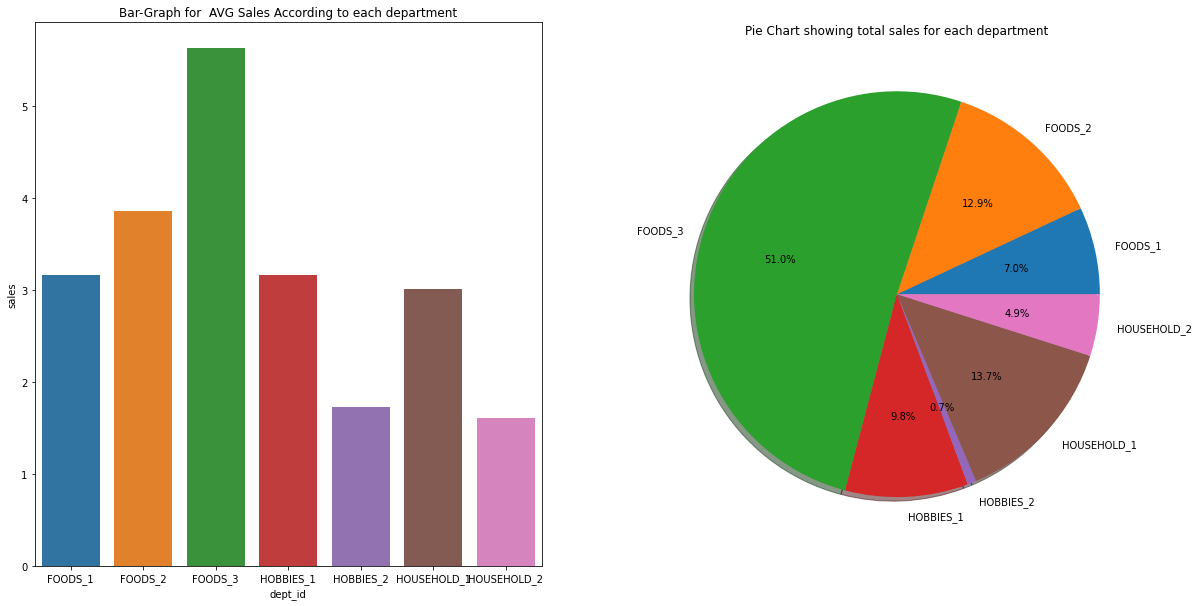

In [ ]:
df=data.groupby('dept_id').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='dept_id',y='sales',data=df)
plt.title("Bar-Graph for  AVG Sales According to each department")
df=data.groupby('dept_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['sales']/sum(df['sales'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['dept_id'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing total sales for each department")

plt.show()

##OBSERVATION
###-For HOBBIES_2 department sales is lowest.
###-For FOODS_3 department sales is highest.
###-Almost 50% of sales are done by FOODS_3 department.

##E. Bargraph for Average sales for each Weekday & Pie chart showing percentage of sales for each Week

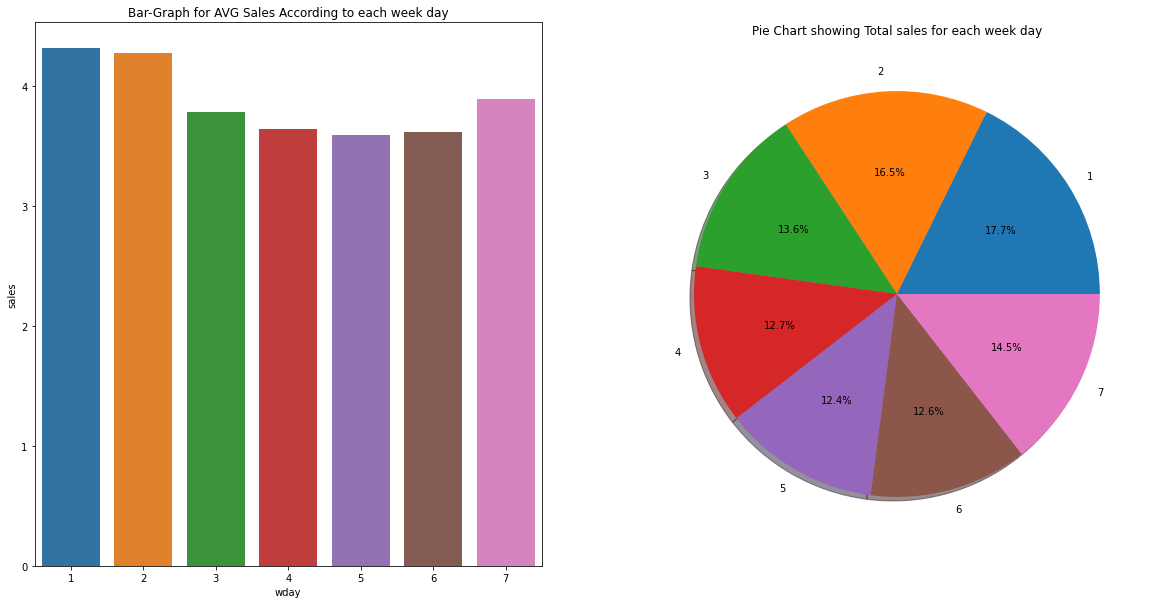

In [ ]:
df=data.groupby('wday').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='wday',y='sales',data=df)
plt.title("Bar-Graph for AVG Sales According to each week day")

df=data.groupby('wday').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['sales']/sum(df['sales'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['wday'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing Total sales for each week day")

plt.show()

###OBSERVATION:

Clearly sales are more on weekends than normal days.
So we must try out to use this weekday feature while training our models.

##F. Bargraph for Average sales for each Month & Pie chart showing percentage of sales for each Month


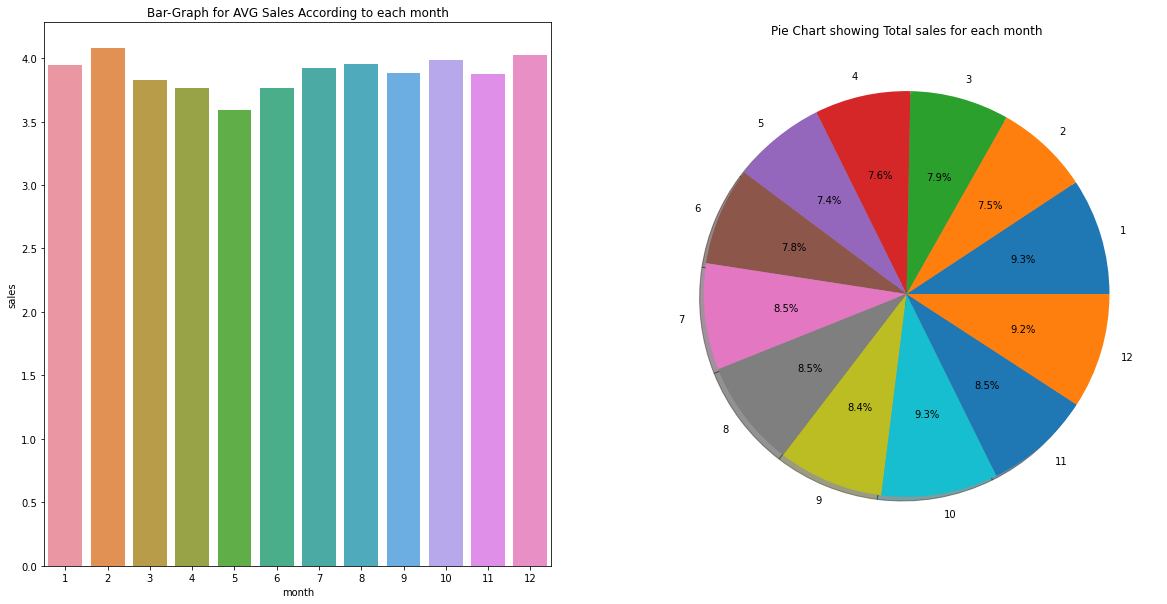

In [ ]:
df=data.groupby('month').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='month',y='sales',data=df)
plt.title("Bar-Graph for AVG Sales According to each month")

df=data.groupby('month').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['sales']/sum(df['sales'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['month'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing Total sales for each month")

plt.show()

##OBSERVATION: Average sales for Month of February(2) is most.

##G. Bargraph for Average sales for each year & Pie chart showing percentage of sales for each year

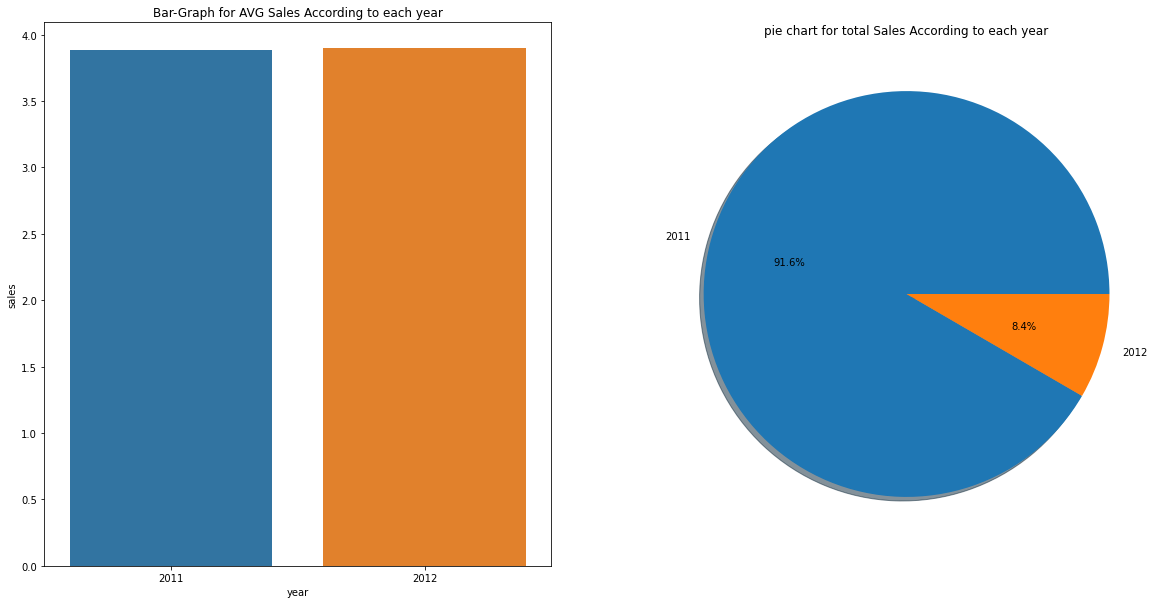

In [ ]:
df=data.groupby('year').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)

sns.barplot(x='year',y='sales',data=df)
plt.title("Bar-Graph for AVG Sales According to each year")

plt.subplot(122)
df=data.groupby('year').sum()
df.reset_index(level=0,inplace=True)
df['year_avg']=df['sales']/sum(df['sales'].values)*100
plt.pie(df['year_avg'].values,labels=df['year'].values,shadow=True,autopct='%1.1f%%')

plt.title("pie chart for total Sales According to each year")
plt.show()

#OBSERVATION:
###-Average sales for year 2015 is least.
###-Average sales for year 2011 is maximum.
###-Total sales are maximum in year 2013

##H.Bargraph for Average sales according to snap_ca value & Pie chart showing percentage of sales according to snap_ca value


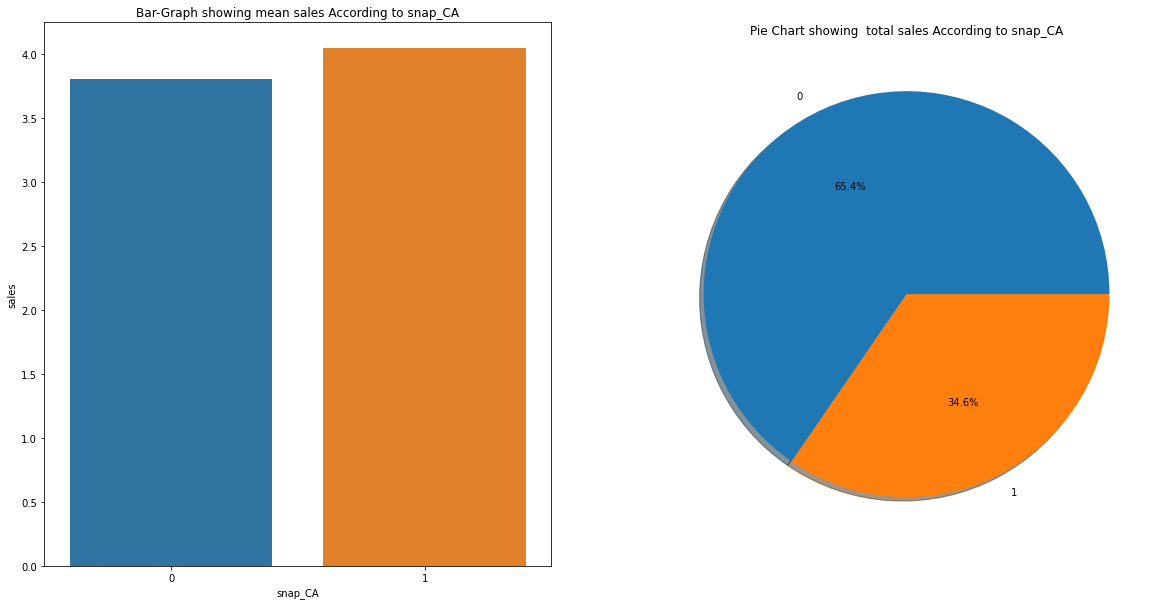

In [ ]:
df=data.groupby('snap_CA').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='snap_CA',y='sales',data=df)
plt.title("Bar-Graph showing mean sales According to snap_CA")

df=data.groupby('snap_CA').sum()
df.reset_index(level=0,inplace=True)
df['snap']=df['sales']/sum(df['sales'].values)*100
plt.subplot(122)
plt.pie(df['snap'].values,labels=df['snap_CA'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing  total sales According to snap_CA")

plt.show()

#OBSERVATION: We get that when we provide snap average sales is more than without snap in California.

##I.Bargraph for Average sales according to snap_tx value & Pie chart showing percentage of sales according to snap_tx value

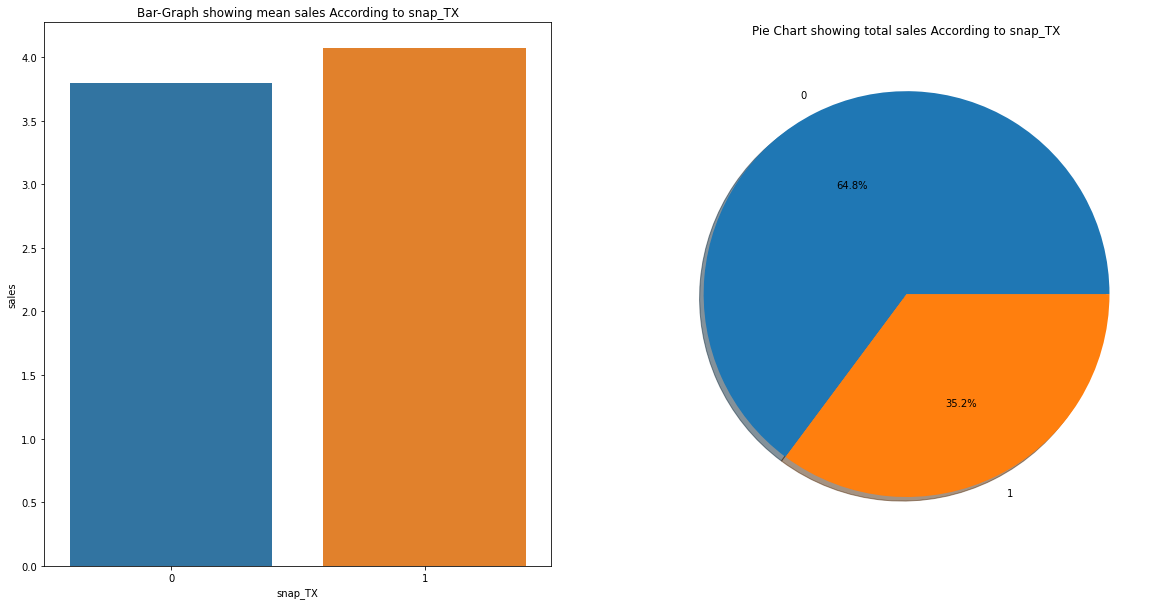

In [ ]:
df=data.groupby('snap_TX').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='snap_TX',y='sales',data=df)
plt.title("Bar-Graph showing mean sales According to snap_TX")

df=data.groupby('snap_TX').sum()
df.reset_index(level=0,inplace=True)
df['snap']=df['sales']/sum(df['sales'].values)*100
plt.subplot(122)
plt.pie(df['snap'].values,labels=df['snap_TX'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing total sales According to snap_TX")

plt.show()

#OBSERVATION: We get that when we provide snap average sales is more than without snap in Texas.

##J. Bargraph for Average sales according to snap_wi value & Pie chart showing percentage of sales according to snap_wi value

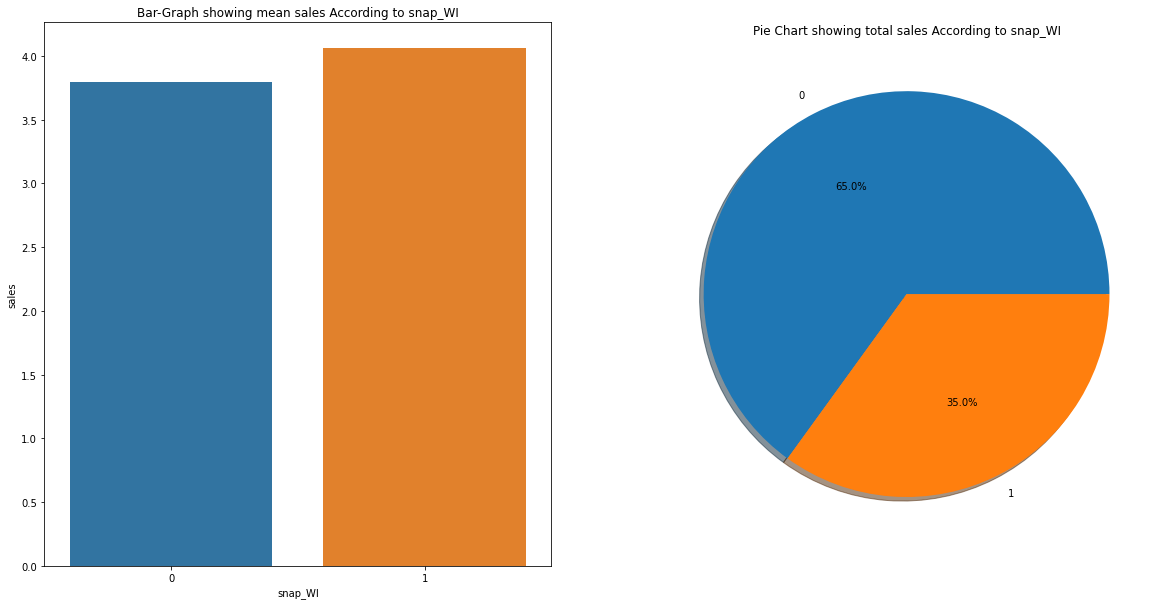

In [ ]:
df=data.groupby('snap_WI').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='snap_WI',y='sales',data=df)
plt.title("Bar-Graph showing mean sales According to snap_WI")

df=data.groupby('snap_WI').sum()
df.reset_index(level=0,inplace=True)
df['snap']=df['sales']/sum(df['sales'].values)*100
plt.subplot(122)
plt.pie(df['snap'].values,labels=df['snap_WI'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing total sales According to snap_WI")

plt.show()

#OBSERVATION: We get that when we provide snap average sales is more than without snap in Wisconsin.

##K.Bargraph for Average sales according to 2 event types & Pie chart showing percentage of sales according to 2 event types

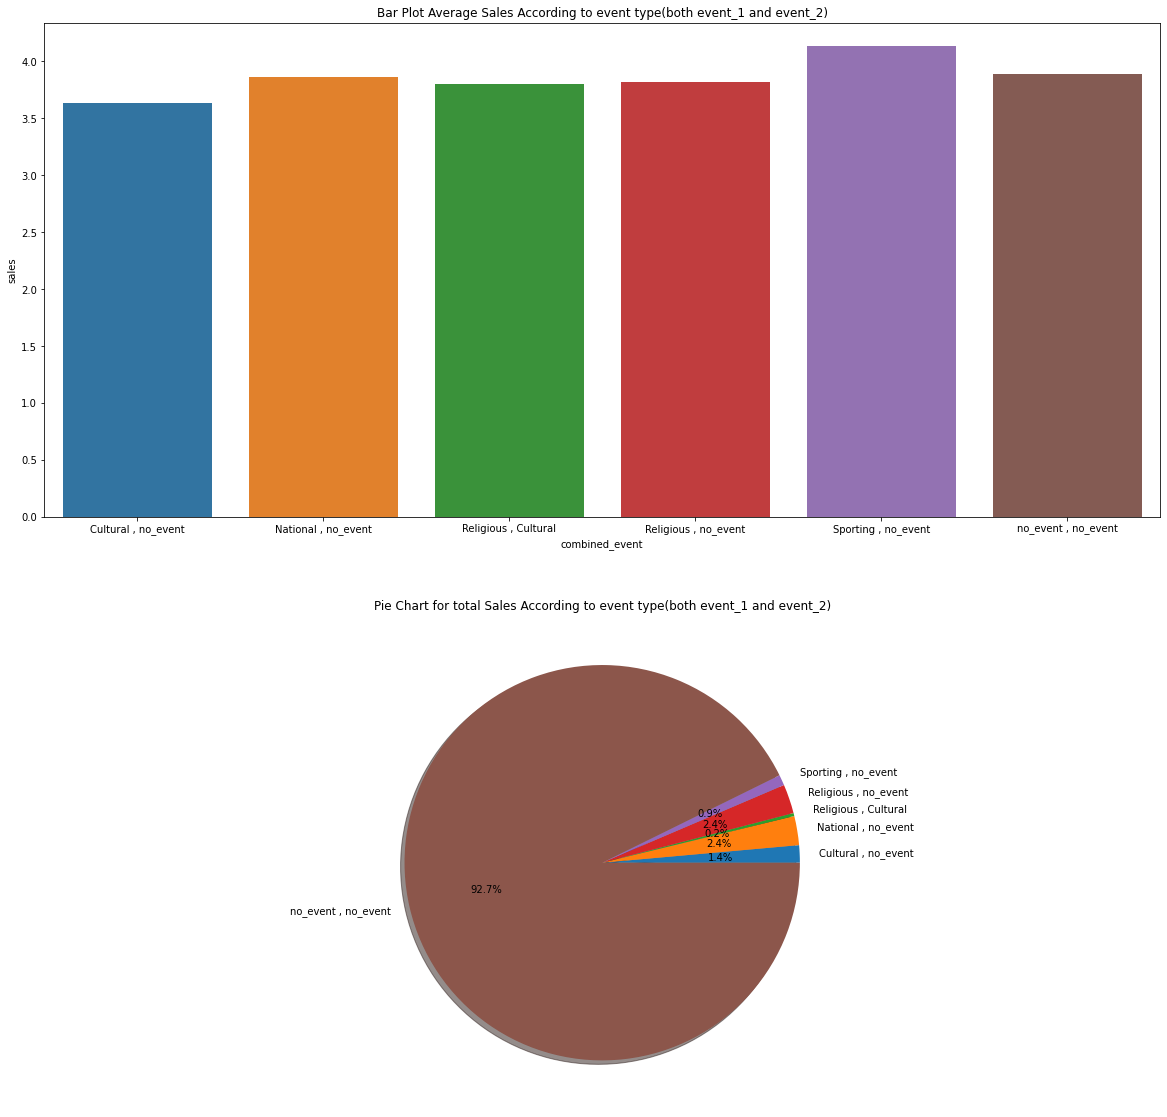

In [ ]:
df=data.groupby(['event_type_1','event_type_2']).mean()
df.reset_index(level=[0,1],inplace=True)
df['combined_event']=df['event_type_1']+" , "+df['event_type_2']
plt.figure(figsize=(20,20))
plt.subplot(211)
sns.barplot(x='combined_event',y='sales',data=df)
plt.title("Bar Plot Average Sales According to event type(both event_1 and event_2)")
df=data.groupby(['event_type_1','event_type_2']).sum()
df.reset_index(level=[0,1],inplace=True)
df['combined_event']=df['event_type_1']+" , "+df['event_type_2']
plt.subplot(212)
df['sales_total']=df['sales']/sum(df['sales'].values)*100
explode = (0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8)
plt.pie(df['sales_total'].values,labels=df['combined_event'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart for total Sales According to event type(both event_1 and event_2)")
plt.show()

#OBSERVATION: Average sales are maximum when we have 2 events of Religious and Cultural type. Thus sales get impacted according to event type.

#Sales According to year & month for Various States

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



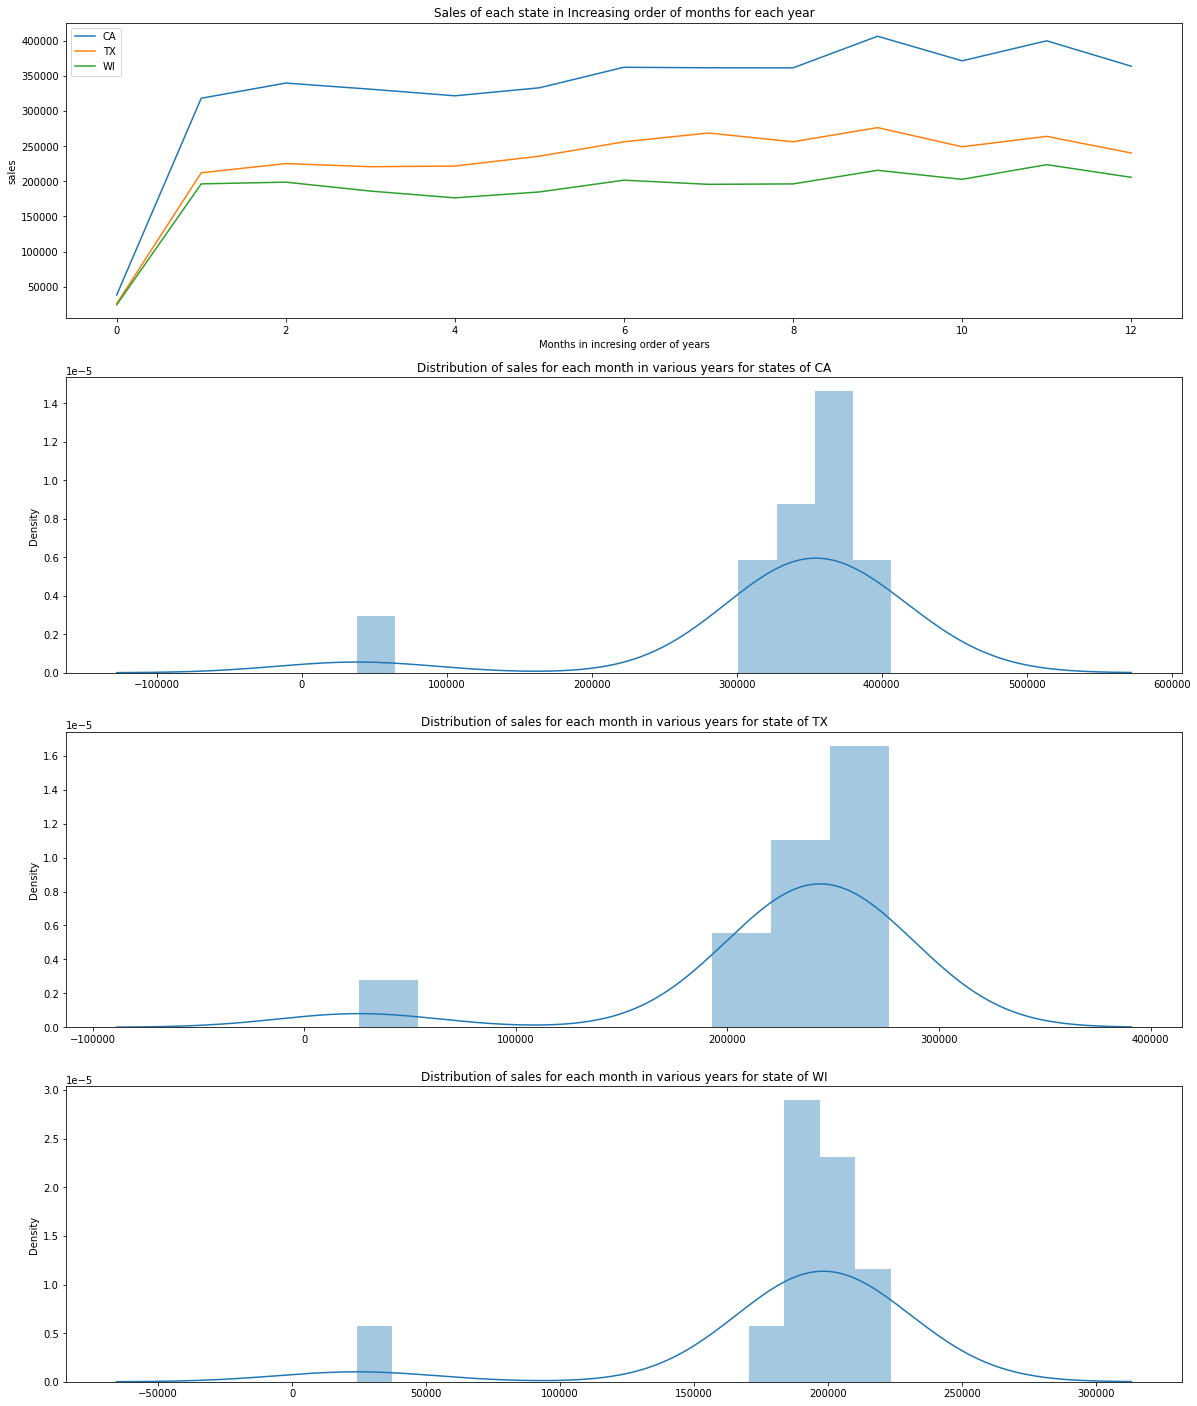

In [ ]:
df=data.groupby(['year','month','state_id']).sum()
df.reset_index(level=[0,1,2],inplace=True)
plt.figure(figsize=(20,25))
plt.subplot(411)
plt.plot(df[df['state_id']=="CA"]['sales'].values,label="CA")
plt.plot(df[df['state_id']=="TX"]['sales'].values,label="TX")
plt.plot(df[df['state_id']=="WI"]['sales'].values,label="WI")
plt.xlabel('Months in incresing order of years')
plt.ylabel('sales')
plt.title("Sales of each state in Increasing order of months for each year")
plt.legend()

plt.subplot(412)
sns.distplot(df[df['state_id']=="CA"]['sales'].values)
plt.title("Distribution of sales for each month in various years for states of CA")

plt.subplot(413)
sns.distplot(df[df['state_id']=="TX"]['sales'].values)
plt.title("Distribution of sales for each month in various years for state of TX")

plt.subplot(414)
sns.distplot(df[df['state_id']=="WI"]['sales'].values)
plt.title("Distribution of sales for each month in various years for state of WI")

plt.show()

#Decompose Time Series Data into Trend and Seasonality

In [ ]:
ids = np.unique(salestv_data.id.values)
date_cols = [c for c in salestv_data.columns if 'd_' in c]
date_range = cal_data['date']
d_st = date_range.values[1]
d_end = date_range.values[365]
    
date_range = pd.date_range(start=d_st, end=d_end)
aggr_array = []
for d in date_cols:
    aggr_array.append(salestv_data[d].values.sum())

daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)


series = daily_time_series_df['Sales']
result = seasonal_decompose(series, model='additive')
result_list = [result.trend, result.seasonal, result.resid, result.observed]

fig = make_subplots(rows=len(result_list), cols=1, subplot_titles=("Trend", "Seasonal", "Residual", "Observed"))

for i, res in enumerate(result_list):
    fig.add_trace(go.Scatter(x=date_range, y=res, showlegend=True, mode='lines'), row=i + 1, col=1)

                  
fig.update_layout(title="Seasonal Decomposition", height=1000, width=1000)
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.update_yaxes(title_text="Value", row=1, col=1)
fig.update_yaxes(title_text="Value", row=2, col=1)
fig.update_yaxes(title_text="Value", row=3, col=1)
fig.update_yaxes(title_text="Value", row=4, col=1)                
fig.show()

#OBSERVATION: Clearly we can see the different components are at play. At this moment we can not be so sure if this is the exact decomposition we want.  The weekly seasonalities & the Monthly seasonality were the sales peaks, shortly after the pay date(assuming monthly pay) are clearly captured.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_range[:140], y=result_list[1][:140], showlegend=True, mode='lines'))
fig.update_layout(title="Seasonal Component", xaxis_title="Date", yaxis_title="Units/Value", height=500, width=800)
fig.show()

#Observations:
Its clear that it shows the weekly fluctuations in the sales data where the sales peaks at weekends(Saturday and Sunday).

Moving to the noise component(noise), the dip at year end is captured there rather being in seasonal trend. 

It would be a good comparison between the Trend part of the decomposition and the overall trend for Observed data. It can bring in an idea how effective our decomposition algorithm is here.Lets bring in polynomial regressor do make a trendline

In [ ]:
aggr_array = []
for d in date_cols:
    aggr_array.append(salestv_data[d].values.sum())

daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)

X_values = range(len(daily_time_series_df))
coeffs = np.polyfit(X_values, daily_time_series_df['Sales'].values, 5)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(X_values)

daily_time_series_df['sales_trend'] = y_hat

# since there are some nan values at the beginning and end lets take those values out.
decomp_trend = result.trend[3:-3]
coeffs = np.polyfit(X_values[3:-3], decomp_trend, 5)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(X_values)

daily_time_series_df['sales_trend_decomp'] = y_hat

fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=daily_time_series_df['Sales'].values,
                             showlegend=True, mode='lines'))
fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=daily_time_series_df['sales_trend'].values, mode='lines',
                        showlegend=True, marker=dict(color="black"), name='observed_trend'))
fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=daily_time_series_df['sales_trend_decomp'].values, mode='lines',
                        showlegend=True, marker=dict(color="orange"), name = 'decomposed trend'))
fig.update_layout(
    title="Observed Sales and trend-line", xaxis_title="Date", yaxis_title="Unit Sales", height=500, width=1000)
fig.show()

Its clear from the plots that, the trendline from seasonal decomposition is quite aligned with the observed trendline. Hence the naive decomposition does a very good job in getting here the trend right.


In [ ]:
series = daily_time_series_df['Sales']
result = seasonal_decompose(series, model='multiplicative')
result_list = [result.trend, result.seasonal, result.resid, result.observed]

fig = make_subplots(rows=len(result_list), cols=1, subplot_titles=("Trend", "Seasonal", "Residual", "Observed"))

for i, res in enumerate(result_list):
    fig.add_trace(go.Scatter(x=date_range, y=res, showlegend=True, mode='lines'), row=i + 1, col=1)

                  
fig.update_layout(title="Seasonal Decomposition", height=1000, width=1000)
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.update_yaxes(title_text="Value", row=1, col=1)
fig.update_yaxes(title_text="Value", row=2, col=1)
fig.update_yaxes(title_text="Value", row=3, col=1)
fig.update_yaxes(title_text="Value", row=4, col=1)                
fig.show()

#Observations
like the additive decomposition, the multiplicative decomposition also churns out similar data set. So here the linearity/non-linearity ddnt matter at all!. The sesonal component clearly identifies what to be multiplied with the data.


In [ ]:
state_ids = np.unique(salestv_data['state_id'].values)
fig = make_subplots(rows=1, cols=3, subplot_titles = state_ids)

for i, st_id in enumerate(state_ids):
    state_wise_df = salestv_data[salestv_data['state_id'] == st_id]
    aggr_array = []
    for d in date_cols:
        aggr_array.append(state_wise_df[d].values.sum())
    daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
    
    X_values = range(len(daily_time_series_df))
    coeffs = np.polyfit(X_values, daily_time_series_df['Sales'].values, 5)
    poly_eqn = np.poly1d(coeffs)
    y_hat = poly_eqn(X_values)

    daily_time_series_df['sales_trend'] = y_hat
    fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=daily_time_series_df['Sales'].values,
                             showlegend=False, mode='lines'), row=1, col=i + 1)
    fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=daily_time_series_df['sales_trend'].values,
                            showlegend=False,marker=dict(color="black"), mode='lines'), row=1, col=i + 1)
fig.update_layout(
    title="State Wise Aggregate Sales & Trend", xaxis_title="Date", yaxis_title="Unit Sales", height=400, width=1100)
fig.show()

We can observe similar trends statewise as well in the above graph. 

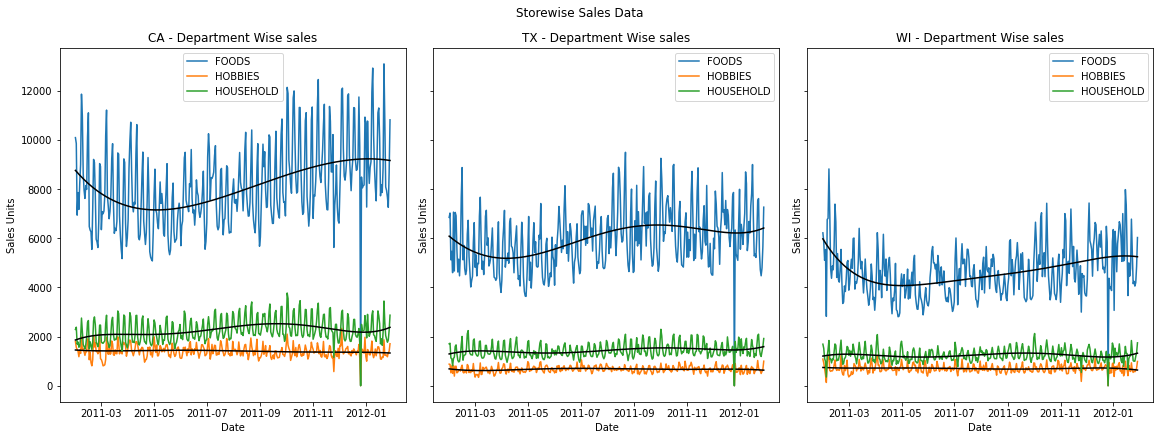

In [ ]:
dept_ids = salestv_data['dept_id'].values
dept_category = []
for d_id in dept_ids:
    dept_category.append(d_id[:-2])
dept_category = np.array(dept_category)

salestv_data['dept_cat'] = dept_category
dept_cat_ids = np.unique(dept_category)

# using matplotlib
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True, constrained_layout=True)
fig.suptitle('Storewise Sales Data')

for i, st_id in enumerate(state_ids):
    state_wise_df = salestv_data[salestv_data['state_id'] == st_id]
    axs[i].set_title('%s - Department Wise sales' % st_id)
    axs[i].set(xlabel='Date', ylabel='Sales Units')
    for j, dp_cat_id in enumerate(dept_cat_ids):
        dept_wise_df = state_wise_df[state_wise_df['dept_cat'] == dp_cat_id]
        aggr_array = []
        for d in date_cols:
            aggr_array.append(dept_wise_df[d].values.sum())
        daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
        
        X_values = range(len(daily_time_series_df))
        coeffs = np.polyfit(X_values, daily_time_series_df['Sales'].values, 5)
        poly_eqn = np.poly1d(coeffs)
        y_hat = poly_eqn(X_values)

        daily_time_series_df['sales_trend'] = y_hat
        axs[i].plot(daily_time_series_df.index, daily_time_series_df['Sales'].values, label='%s' % dp_cat_id)
        axs[i].plot(daily_time_series_df.index, daily_time_series_df['sales_trend'].values, color = 'black')
        axs[i].legend()
plt.show()

Food is the wild card here with maximum fluctuations observed. 

<ipython-input-218-780bf17de493>:24: UserWarning:

This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 



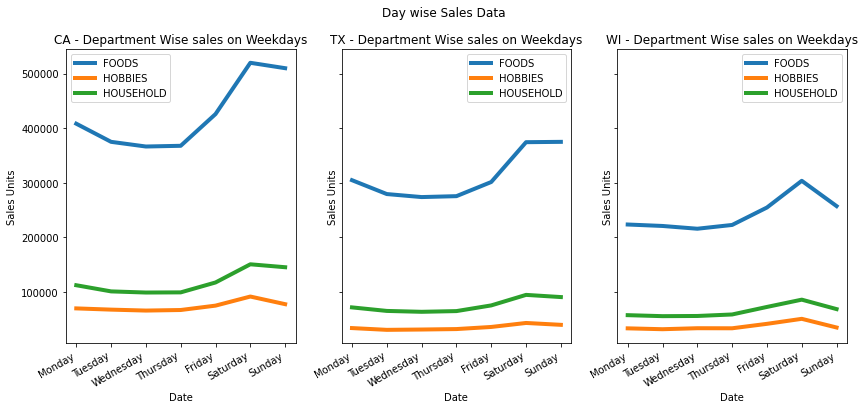

In [ ]:
fig, axs = plt.subplots(1, len(state_ids), figsize=(14, 6), sharey=True, constrained_layout=True)
fig.suptitle('Day wise Sales Data')
weekdays = cal_data['weekday'][:365]
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, st_id in enumerate(state_ids):
    state_wise_df = salestv_data[salestv_data['state_id'] == st_id]
    for dp_cat_id in dept_cat_ids:
        dept_wise_df = state_wise_df[state_wise_df['dept_cat'] == dp_cat_id]
        aggr_array = []
        for d in date_cols:
            aggr_array.append(dept_wise_df[d].values.sum())
        daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
        daily_time_series_df['weekday'] = weekdays.values
        weekly_data = []
        for w in weekday_names:
            day_wise_sum = (daily_time_series_df[daily_time_series_df['weekday'] == w])['Sales'].values.sum()
            weekly_data.append(day_wise_sum)

        axs[i].plot(weekday_names, weekly_data, label='%s' % dp_cat_id, linewidth=4)
        axs[i].legend()
    axs[i].set_title('%s - Department Wise sales on Weekdays' % st_id)
    axs[i].set(xlabel='Date', ylabel='Sales Units')
fig.autofmt_xdate(rotation=30)
plt.show()

# Feature Engineering
##We try to create two new features, weather data and median income through feature engineering.

##We have taken the weather data from the National Oceanic and Atmospheric Administration website. 

In [ ]:
data.shape

(2487327, 22)

In [ ]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.46000
1,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_2,15,2011-01-30,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.46000
2,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_6,4,2011-02-03,11101,...,2,2011,no_event,no_event,no_event,no_event,1,1,1,0.46000
3,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_7,6,2011-02-04,11101,...,2,2011,no_event,no_event,no_event,no_event,1,0,0,0.46000
4,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,1.56000


In [ ]:
df = data.copy()

In [ ]:
df.shape

(2487327, 22)

In [ ]:
df = df.groupby(["d", "cat_id","date","weekday","month","event_name_1","event_type_1","snap_CA","snap_TX","snap_WI"]).sales.sum().reset_index()

In [ ]:
df.shape

(1093, 11)

In [ ]:
df.head()

,d,cat_id,date,weekday,month,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sales
0,d_1,FOODS,2011-01-29,Saturday,1,no_event,no_event,0,0,0,23178
1,d_1,HOBBIES,2011-01-29,Saturday,1,no_event,no_event,0,0,0,3764
2,d_1,HOUSEHOLD,2011-01-29,Saturday,1,no_event,no_event,0,0,0,5689
3,d_10,FOODS,2011-02-07,Monday,2,no_event,no_event,1,1,0,18901
4,d_10,HOBBIES,2011-02-07,Monday,2,no_event,no_event,1,1,0,2615


In [ ]:
finalData = df.pivot(index='d', columns='cat_id')['sales']

In [ ]:
finalData

cat_id,FOODS,HOBBIES,HOUSEHOLD
d,,,
d_1,23178.00000,3764.00000,5689.00000
d_10,18901.00000,2615.00000,4056.00000
d_100,16383.00000,2880.00000,4425.00000
d_101,17988.00000,2670.00000,4366.00000
d_102,15767.00000,2584.00000,3880.00000
...,...,...,...
d_95,16581.00000,3002.00000,4497.00000
d_96,14160.00000,2549.00000,4052.00000
d_97,14778.00000,2605.00000,3801.00000


In [ ]:
df = df.merge(finalData, on="d")

In [ ]:
df.head()

,d,cat_id,date,weekday,month,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sales,FOODS,HOBBIES,HOUSEHOLD
0,d_1,FOODS,2011-01-29,Saturday,1,no_event,no_event,0,0,0,23178,23178.00000,3764.00000,5689.00000
1,d_1,HOBBIES,2011-01-29,Saturday,1,no_event,no_event,0,0,0,3764,23178.00000,3764.00000,5689.00000
2,d_1,HOUSEHOLD,2011-01-29,Saturday,1,no_event,no_event,0,0,0,5689,23178.00000,3764.00000,5689.00000
3,d_10,FOODS,2011-02-07,Monday,2,no_event,no_event,1,1,0,18901,18901.00000,2615.00000,4056.00000
4,d_10,HOBBIES,2011-02-07,Monday,2,no_event,no_event,1,1,0,2615,18901.00000,2615.00000,4056.00000


In [ ]:
df = df.drop(['cat_id'], axis=1)

In [ ]:
df.drop_duplicates(subset=['d'], keep="first", inplace = True)

In [ ]:
df.head()

,d,date,weekday,month,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sales,FOODS,HOBBIES,HOUSEHOLD
0,d_1,2011-01-29,Saturday,1,no_event,no_event,0,0,0,23178,23178.00000,3764.00000,5689.00000
3,d_10,2011-02-07,Monday,2,no_event,no_event,1,1,0,18901,18901.00000,2615.00000,4056.00000
6,d_100,2011-05-08,Sunday,5,Mother's day,Cultural,1,0,1,16383,16383.00000,2880.00000,4425.00000
9,d_101,2011-05-09,Monday,5,no_event,no_event,1,1,1,17988,17988.00000,2670.00000,4366.00000
12,d_102,2011-05-10,Tuesday,5,no_event,no_event,1,0,0,15767,15767.00000,2584.00000,3880.00000


In [ ]:
df_test = data_test.copy()
df_test = df_test.groupby(["d", "cat_id","date","weekday","month","event_name_1","event_type_1","snap_CA","snap_TX","snap_WI"]).sales.sum().reset_index()
finalData_test = df_test.pivot(index='d', columns='cat_id')['sales']
df_test = df_test.merge(finalData, on="d")
df_test = df_test.drop(['cat_id','sales'], axis = 1)
df_test.drop_duplicates(subset=['d'], keep="first", inplace = True)

In [ ]:
data_test.shape

(2487327, 23)

In [ ]:
data_test = data_test.iloc[292:]

In [ ]:
data_test.shape

(2487035, 23)

In [ ]:
weather = pd.read_csv('/content/drive/MyDrive/dataset2/weather.csv')
weather.columns

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'WT01',
       'WT03', 'WT04', 'WT05', 'WT06', 'WT11'],
      dtype='object')

In [ ]:
weather.sample(5)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,WT01,WT03,WT04,WT05,WT06,WT11
11100,USC00413370,"FRISCO, TX US",33.19240,-96.79300,227.70000,2014-12-17,NaN,NaN,NaN,NaN,NaN,NaN
10548,USC00413370,"FRISCO, TX US",33.19240,-96.79300,227.70000,2013-06-13,NaN,NaN,NaN,NaN,NaN,NaN
14536,USR0000CLGA,"LOS GATOS CALIFORNIA, CA US",37.20280,-121.94280,609.60000,2011-02-16,NaN,NaN,NaN,NaN,NaN,NaN
1258,US1TXRK0006,"ROCKWALL 3.1 SSW, TX US",32.88316,-96.48426,137.20000,2016-05-02,NaN,NaN,NaN,NaN,NaN,NaN
11278,USC00413370,"FRISCO, TX US",33.19240,-96.79300,227.70000,2015-06-13,NaN,NaN,NaN,NaN,NaN,NaN


Here, we can see the fields of weather data, it shows weather according to the zip code of the location, and also takes into consideration the elevation of that location. It can be observed that weather is classified into 6 different classes, viz, WT01, WT03, WT04, WT05, WT06 and WT11. We can also observe that there is no common field in the weather dataset and the other given datasets.

To make this connection, we map unique entities of the column “NAME” in the weather dataset to the column “store_id” in the sales_train_validation dataset.

In [ ]:
weather[['WT01','WT03', 'WT04', 'WT05', 'WT06', 'WT11']] = weather[['WT01','WT03', 'WT04', 'WT05', 'WT06', 'WT11']].fillna(0)
def randWTCol():
  return 5 + np.random.randint(low=1, high=7)

for row in range(weather.shape[0]):
  if int(weather.iloc[row:row+1,6:12].sum(axis=1)) == 0:
    rand_WT_col_in_row = randWTCol()
    weather.iloc[row:row+1, rand_WT_col_in_row:rand_WT_col_in_row+1] = 1

def map_location_code(location):
  map_location_code = {
      'LONG':'CA_1',
      'LOS':'CA_2',
      'SAN':'CA_3',
      'FREMONT':'CA_4',
      'FREMONT,':'CA_4',
      'ROCKWALL':'TX_1',
      'FRISCO':'TX_2',
      'FRISCO,':'TX_2',
      'SACHSE':'TX_3',
      'WATERTOWN':'WI_1',
      'MEQUON':'WI_2',
      'THERESA':'WI_3'     
  }
  try:
    return map_location_code[location.split(' ')[0]]
  except:
    return location
    
weather['store_id'] = weather.apply(lambda row: map_location_code(row['NAME']), axis=1)

weather['date'] = pd.to_datetime(weather['DATE'])
weather['d'] = pd.to_datetime('2011-01-29')
weather['d'] = ((weather['date'] - weather['d']).dt.days + 1).astype(str) # 2011-01-29 should be 1, not 0
weather['d'] = 'd_'+ weather['d']

In [ ]:
display(weather)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,WT01,WT03,WT04,WT05,WT06,WT11,store_id,date,d
0,US1CAAL0024,"FREMONT 3.7 NE, CA US",37.57197,-121.95903,31.10000,2014-12-18,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,CA_4,2014-12-18,d_1420
1,US1CAAL0024,"FREMONT 3.7 NE, CA US",37.57197,-121.95903,31.10000,2014-12-19,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,CA_4,2014-12-19,d_1421
2,US1CAAL0024,"FREMONT 3.7 NE, CA US",37.57197,-121.95903,31.10000,2014-12-20,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,CA_4,2014-12-20,d_1422
3,US1CAAL0024,"FREMONT 3.7 NE, CA US",37.57197,-121.95903,31.10000,2014-12-21,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,CA_4,2014-12-21,d_1423
4,US1CAAL0024,"FREMONT 3.7 NE, CA US",37.57197,-121.95903,31.10000,2014-12-25,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,CA_4,2014-12-25,d_1427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18389,USC00043244,"FREMONT, CA US",37.54220,-122.01580,11.60000,2016-06-15,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,CA_4,2016-06-15,d_1965
18390,USC00043244,"FREMONT, CA US",37.54220,-122.01580,11.60000,2016-06-16,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,CA_4,2016-06-16,d_1966
18391,USC00043244,"FREMONT, CA US",37.54220,-122.01580,11.60000,2016-06-17,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,CA_4,2016-06-17,d_1967
18392,USC00043244,"FREMONT, CA US",37.54220,-122.01580,11.60000,2016-06-18,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,CA_4,2016-06-18,d_1968


In [ ]:
weather = weather.drop(['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION','DATE'], axis = 1)

In [ ]:
weather.rename(columns={'LOCATION_CODE': 'store_id', 'DATE_COUNT': 'd'}, inplace=True)

In [ ]:
weather.sample(10)

,NAME,WT01,WT03,WT04,WT05,WT06,WT11,store_id,date,d
7252,"SACHSE 1.0 NE, TX US",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,TX_3,2015-10-24,d_1730
5906,"WATERTOWN 1.6 ESE, WI US",0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,WI_1,2014-05-21,d_1209
12765,"CEDARBURG 3.7 WSW, WI US",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,"CEDARBURG 3.7 WSW, WI US",2016-06-16,d_1966
6083,"WATERTOWN 1.6 ESE, WI US",0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,WI_1,2015-08-07,d_1652
12798,"THERESA 0.5 SSW, WI US",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,WI_3,2016-04-10,d_1899
10935,"FRISCO, TX US",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,TX_2,2014-07-05,d_1254
10958,"FRISCO, TX US",0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,TX_2,2014-07-28,d_1277
11819,"CEDARBURG 3.7 WSW, WI US",0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,"CEDARBURG 3.7 WSW, WI US",2011-06-10,d_133
10129,"FRISCO, TX US",0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,TX_2,2012-04-20,d_448
17235,"FREMONT, CA US",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,CA_4,2013-03-31,d_793


In [ ]:
data_features = data_features.drop(['id','item_id','state_id','wm_yr_wk'], axis = 1)
data_features.head()

,dept_id,cat_id,store_id,d,sales,date,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1,HOBBIES,CA_1,d_1,12,2011-01-29,Saturday,1,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.46000
1,HOBBIES_1,HOBBIES,CA_1,d_2,15,2011-01-30,Sunday,2,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.46000
2,HOBBIES_1,HOBBIES,CA_1,d_6,4,2011-02-03,Thursday,6,2,2011,no_event,no_event,no_event,no_event,1,1,1,0.46000
3,HOBBIES_1,HOBBIES,CA_1,d_7,6,2011-02-04,Friday,7,2,2011,no_event,no_event,no_event,no_event,1,0,0,0.46000
4,HOBBIES_1,HOBBIES,CA_1,d_1,2,2011-01-29,Saturday,1,1,2011,no_event,no_event,no_event,no_event,0,0,0,1.56000


In [ ]:
data_features['date'] = pd.to_datetime(data_features['date'])

In [ ]:
data = df.copy()

In [ ]:
data_features = pd.merge(data_features,weather)
data_features.head()

,dept_id,cat_id,store_id,d,sales,date,weekday,wday,month,year,...,snap_TX,snap_WI,sell_price,NAME,WT01,WT03,WT04,WT05,WT06,WT11
0,HOBBIES_1,HOBBIES,CA_2,d_1,6,2011-01-29,Saturday,1,1,2011,...,0,0,4.34000,"LOS GATOS, CA US",0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
1,HOBBIES_1,HOBBIES,CA_2,d_1,6,2011-01-29,Saturday,1,1,2011,...,0,0,4.34000,"LOS GATOS CALIFORNIA, CA US",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
2,HOBBIES_1,HOBBIES,CA_2,d_1,2,2011-01-29,Saturday,1,1,2011,...,0,0,1.56000,"LOS GATOS, CA US",0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
3,HOBBIES_1,HOBBIES,CA_2,d_1,2,2011-01-29,Saturday,1,1,2011,...,0,0,1.56000,"LOS GATOS CALIFORNIA, CA US",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
4,HOBBIES_1,HOBBIES,CA_2,d_1,23,2011-01-29,Saturday,1,1,2011,...,0,0,0.70000,"LOS GATOS, CA US",0.00000,0.00000,0.00000,0.00000,1.00000,0.00000


#Observation: Here we can see that each row now has a corresponding store ID as well as a day number, which is similar to the sales_train_validation dataset and now we can easily merge these two datasets to make better predictions.

## Feature Engineering : Median Income 

In [ ]:
income_2011 = pd.read_csv('/content/drive/MyDrive/dataset2/ACSST5Y2011.S1903-Data.csv')
income_2012 = pd.read_csv('/content/drive/MyDrive/dataset2/ACSST5Y2012.S1903-Data.csv')

In [ ]:
income_2011 = income_2011.drop(income_2011.loc[:, 'S1903_C02_001MA':'S1903_C02_030MA'].columns, axis=1)
income_2011 = income_2011.drop(income_2011.loc[:, 'S1903_C01_001E':'S1903_C01_001EA'].columns, axis=1)
income_2011 = income_2011.drop(income_2011.loc[:, 'S1903_C02_001M':'Unnamed: 242'].columns, axis=1)
income_2011.shape
income_2011.columns

Index(['GEO_ID', 'NAME', 'S1903_C02_001E'], dtype='object')

In [ ]:
income_2012 = income_2012.drop(income_2012.loc[:, 'S1903_C02_001MA':'S1903_C02_030MA'].columns, axis=1)
income_2012 = income_2012.drop(income_2012.loc[:, 'S1903_C01_001E':'S1903_C01_001EA'].columns, axis=1)
income_2012 = income_2012.drop(income_2012.loc[:, 'S1903_C02_001M':'Unnamed: 242'].columns, axis=1)
income_2012.shape
income_2012.columns

Index(['GEO_ID', 'NAME', 'S1903_C02_001E'], dtype='object')

In [ ]:
income_2011 = income_2011.drop('GEO_ID', axis = 1)
income_2012 = income_2012.drop('GEO_ID', axis = 1)

In [ ]:
income_2012 = income_2012.drop(0, axis = 0)
income_2011 = income_2011.drop(0, axis = 0)

In [ ]:
income_2011['S1903_C02_001E'] = income_2011['S1903_C02_001E'].astype(int)
income_2012['S1903_C02_001E'] = income_2012['S1903_C02_001E'].astype(int)

##Creating a new row for the zip code "75033" (as we did not find any income data for that zip code) and filling it with the average of all the median incomes.

In [ ]:
df_2011 = pd.DataFrame(income_2011)
median_avg_2011 = df_2011["S1903_C02_001E"].mean()
new_zip_2011 = {'NAME' : 'ZCTA5 75033', 'S1903_C02_001E' : median_avg_2011}
df_2011 = df_2011.append(new_zip_2011, ignore_index = True)
df_2011['S1903_C02_001E'] = df_2011['S1903_C02_001E'].astype(int)
display(df_2011)

,NAME,S1903_C02_001E
0,ZCTA5 53091,56830
1,ZCTA5 53092,99123
2,ZCTA5 53094,51205
3,ZCTA5 75032,92526
4,ZCTA5 75048,87721
5,ZCTA5 90804,43489
6,ZCTA5 92107,60673
7,ZCTA5 94536,84840
8,ZCTA5 95032,118713
9,ZCTA5 75033,77235


In [ ]:
df_2012 = pd.DataFrame(income_2012)
median_avg_2012 = df_2012["S1903_C02_001E"].mean()
new_zip_2012 = {'NAME' : 'ZCTA5 75033', 'S1903_C02_001E' : median_avg_2012}
df_2012 = df_2012.append(new_zip_2012, ignore_index = True)
df_2012['S1903_C02_001E'] = df_2012['S1903_C02_001E'].astype(int)
display(df_2012)

,NAME,S1903_C02_001E
0,ZCTA5 53091,55052
1,ZCTA5 53092,96083
2,ZCTA5 53094,50422
3,ZCTA5 75032,91456
4,ZCTA5 75048,88691
5,ZCTA5 90804,41642
6,ZCTA5 92107,61680
7,ZCTA5 94536,85196
8,ZCTA5 95032,122512
9,ZCTA5 75033,76970


### Attaching new columns, "Year" and "Store_ID" to both df_2011 and df_2012 data frames.

In [ ]:
df_2011["Year"] = 2011
display(df_2011)

,NAME,S1903_C02_001E,Year
0,ZCTA5 53091,56830,2011
1,ZCTA5 53092,99123,2011
2,ZCTA5 53094,51205,2011
3,ZCTA5 75032,92526,2011
4,ZCTA5 75048,87721,2011
5,ZCTA5 90804,43489,2011
6,ZCTA5 92107,60673,2011
7,ZCTA5 94536,84840,2011
8,ZCTA5 95032,118713,2011
9,ZCTA5 75033,77235,2011


In [ ]:
df_2012["Year"] = 2012
display(df_2012)

,NAME,S1903_C02_001E,Year
0,ZCTA5 53091,55052,2012
1,ZCTA5 53092,96083,2012
2,ZCTA5 53094,50422,2012
3,ZCTA5 75032,91456,2012
4,ZCTA5 75048,88691,2012
5,ZCTA5 90804,41642,2012
6,ZCTA5 92107,61680,2012
7,ZCTA5 94536,85196,2012
8,ZCTA5 95032,122512,2012
9,ZCTA5 75033,76970,2012


In [ ]:
# def store_id_map(store):
store_id_map = {'ZCTA5 53091' : 'WI_3', 
                'ZCTA5 53092' : 'WI_2', 
                'ZCTA5 53094' : 'WI_1',
                'ZCTA5 75032' : 'TX_1',
                'ZCTA5 75033' : 'TX_2',
                'ZCTA5 75048' : 'TX_3',
                'ZCTA5 90804' : 'CA_1',
                'ZCTA5 92107' : 'CA_3',
                'ZCTA5 94536' : 'CA_4',
                'ZCTA5 95032' : 'CA_2'}
  # try:
  #   return store_id_map[store.split(' ')[0]]
  # except:
  #   return store

df_2011['store_ID'] = df_2011['NAME'].map(store_id_map)
display(df_2011)

,NAME,S1903_C02_001E,Year,store_ID
0,ZCTA5 53091,56830,2011,WI_3
1,ZCTA5 53092,99123,2011,WI_2
2,ZCTA5 53094,51205,2011,WI_1
3,ZCTA5 75032,92526,2011,TX_1
4,ZCTA5 75048,87721,2011,TX_3
5,ZCTA5 90804,43489,2011,CA_1
6,ZCTA5 92107,60673,2011,CA_3
7,ZCTA5 94536,84840,2011,CA_4
8,ZCTA5 95032,118713,2011,CA_2
9,ZCTA5 75033,77235,2011,TX_2


In [ ]:
df_2012['store_ID'] = df_2012['NAME'].map(store_id_map)
display(df_2012)

,NAME,S1903_C02_001E,Year,store_ID
0,ZCTA5 53091,55052,2012,WI_3
1,ZCTA5 53092,96083,2012,WI_2
2,ZCTA5 53094,50422,2012,WI_1
3,ZCTA5 75032,91456,2012,TX_1
4,ZCTA5 75048,88691,2012,TX_3
5,ZCTA5 90804,41642,2012,CA_1
6,ZCTA5 92107,61680,2012,CA_3
7,ZCTA5 94536,85196,2012,CA_4
8,ZCTA5 95032,122512,2012,CA_2
9,ZCTA5 75033,76970,2012,TX_2


In [ ]:
df = pd.concat([df_2011, df_2012], axis=0)
display(df)

,NAME,S1903_C02_001E,Year,store_ID
0,ZCTA5 53091,56830,2011,WI_3
1,ZCTA5 53092,99123,2011,WI_2
2,ZCTA5 53094,51205,2011,WI_1
3,ZCTA5 75032,92526,2011,TX_1
4,ZCTA5 75048,87721,2011,TX_3
5,ZCTA5 90804,43489,2011,CA_1
6,ZCTA5 92107,60673,2011,CA_3
7,ZCTA5 94536,84840,2011,CA_4
8,ZCTA5 95032,118713,2011,CA_2
9,ZCTA5 75033,77235,2011,TX_2


In [ ]:
df = df.drop('NAME', axis = 1)

In [ ]:
# changing the names of the columns so that we can merge this dataframe to the combined dataset
df.rename(columns = {'S1903_C02_001E':'Med_Income', 'Year':'year', 'store_ID' : 'store_id'}, inplace = True)

In [ ]:
data_features = pd.merge(data_features,df)

In [ ]:
data_features.columns

Index(['dept_id', 'cat_id', 'store_id', 'd', 'sales', 'date', 'weekday',
       'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'NAME',
       'WT01', 'WT03', 'WT04', 'WT05', 'WT06', 'WT11', 'Med_Income'],
      dtype='object')

In [ ]:
data_features = data_features.drop(['dept_id','wday','year','event_name_2','event_type_2','sell_price'], axis = 1)
data_features.head()

,cat_id,store_id,d,sales,date,weekday,month,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,NAME,WT01,WT03,WT04,WT05,WT06,WT11,Med_Income
0,HOBBIES,CA_2,d_1,6,2011-01-29,Saturday,1,no_event,no_event,0,0,0,"LOS GATOS, CA US",0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,118713
1,HOBBIES,CA_2,d_1,6,2011-01-29,Saturday,1,no_event,no_event,0,0,0,"LOS GATOS CALIFORNIA, CA US",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,118713
2,HOBBIES,CA_2,d_1,2,2011-01-29,Saturday,1,no_event,no_event,0,0,0,"LOS GATOS, CA US",0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,118713
3,HOBBIES,CA_2,d_1,2,2011-01-29,Saturday,1,no_event,no_event,0,0,0,"LOS GATOS CALIFORNIA, CA US",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,118713
4,HOBBIES,CA_2,d_1,23,2011-01-29,Saturday,1,no_event,no_event,0,0,0,"LOS GATOS, CA US",0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,118713


In [ ]:
df_feat = data_features.copy()
df_feat = df_feat.groupby(["d","cat_id","date","weekday","month","event_name_1","event_type_1","snap_CA","snap_TX","snap_WI","NAME","WT01","WT03","WT04","WT05","WT06","WT11","Med_Income"]).sales.sum().reset_index()

In [ ]:
df_feat.head()

,d,cat_id,date,weekday,month,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,NAME,WT01,WT03,WT04,WT05,WT06,WT11,Med_Income,sales
0,d_1,FOODS,2011-01-29,Saturday,1,no_event,no_event,0,0,0,"FREMONT, CA US",0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,84840,1223
1,d_1,FOODS,2011-01-29,Saturday,1,no_event,no_event,0,0,0,"FRISCO 1.9 N, TX US",0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,77235,2788
2,d_1,FOODS,2011-01-29,Saturday,1,no_event,no_event,0,0,0,"FRISCO, TX US",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,77235,2788
3,d_1,FOODS,2011-01-29,Saturday,1,no_event,no_event,0,0,0,"LOS GATOS CALIFORNIA, CA US",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,118713,2193
4,d_1,FOODS,2011-01-29,Saturday,1,no_event,no_event,0,0,0,"LOS GATOS, CA US",0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,118713,2193


In [ ]:
df_feat.drop_duplicates(subset=['d'], keep="last", inplace = True)

In [ ]:
finalData_feat = df_feat.pivot(index='d', columns='cat_id')['sales']
df_feat = df_feat.merge(finalData, on="d")
df_feat = df_feat.drop(['cat_id','sales'], axis = 1)

In [ ]:
df_feat.head()

,d,date,weekday,month,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,NAME,WT01,WT03,WT04,WT05,WT06,WT11,Med_Income,FOODS,HOBBIES,HOUSEHOLD
0,d_1,2011-01-29,Saturday,1,no_event,no_event,0,0,0,"WATERTOWN WWTP, WI US",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,51205,23178.00000,3764.00000,5689.00000
1,d_10,2011-02-07,Monday,2,no_event,no_event,1,1,0,"WATERTOWN WWTP, WI US",0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,51205,18901.00000,2615.00000,4056.00000
2,d_100,2011-05-08,Sunday,5,Mother's day,Cultural,1,0,1,"WATERTOWN WWTP, WI US",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,51205,16383.00000,2880.00000,4425.00000
3,d_101,2011-05-09,Monday,5,no_event,no_event,1,1,1,"WATERTOWN WWTP, WI US",0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,51205,17988.00000,2670.00000,4366.00000
4,d_102,2011-05-10,Tuesday,5,no_event,no_event,1,0,0,"WATERTOWN WWTP, WI US",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,51205,15767.00000,2584.00000,3880.00000


#Time Series Data Analysis

##To get an idea of the modeling, we will try to pridict result using Time series. Further, predicting total sales in each category Foods, Hobbies & Household.

In [ ]:
data = df_feat.copy()

In [ ]:
data['FOODS'].isnull().values.any()

False

In [ ]:
data.head()

,d,date,weekday,month,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,NAME,WT01,WT03,WT04,WT05,WT06,WT11,Med_Income,FOODS,HOBBIES,HOUSEHOLD
0,d_1,2011-01-29,Saturday,1,no_event,no_event,0,0,0,"WATERTOWN WWTP, WI US",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,51205,23178.00000,3764.00000,5689.00000
1,d_10,2011-02-07,Monday,2,no_event,no_event,1,1,0,"WATERTOWN WWTP, WI US",0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,51205,18901.00000,2615.00000,4056.00000
2,d_100,2011-05-08,Sunday,5,Mother's day,Cultural,1,0,1,"WATERTOWN WWTP, WI US",0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,51205,16383.00000,2880.00000,4425.00000
3,d_101,2011-05-09,Monday,5,no_event,no_event,1,1,1,"WATERTOWN WWTP, WI US",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,51205,17988.00000,2670.00000,4366.00000
4,d_102,2011-05-10,Tuesday,5,no_event,no_event,1,0,0,"WATERTOWN WWTP, WI US",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,51205,15767.00000,2584.00000,3880.00000


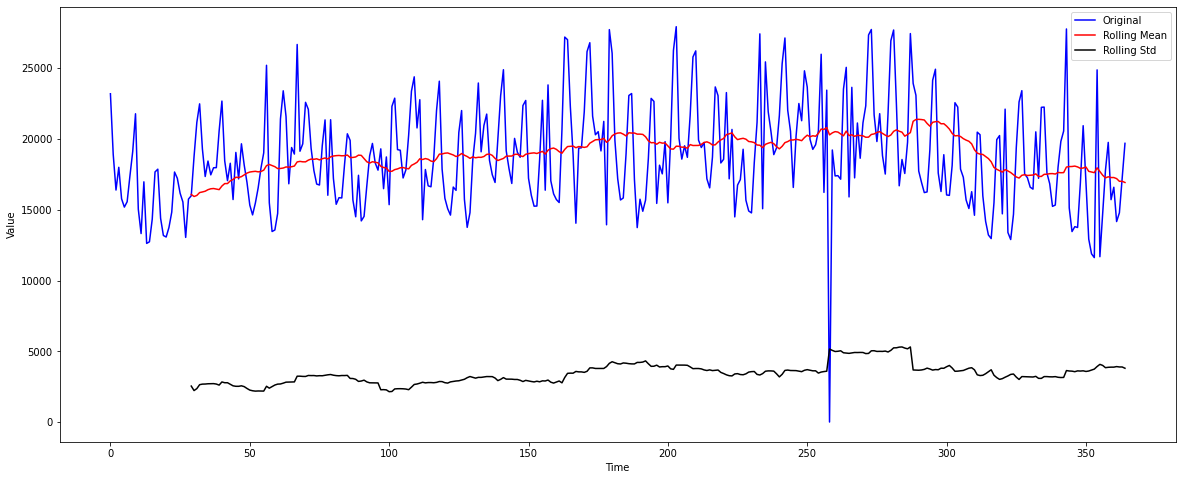

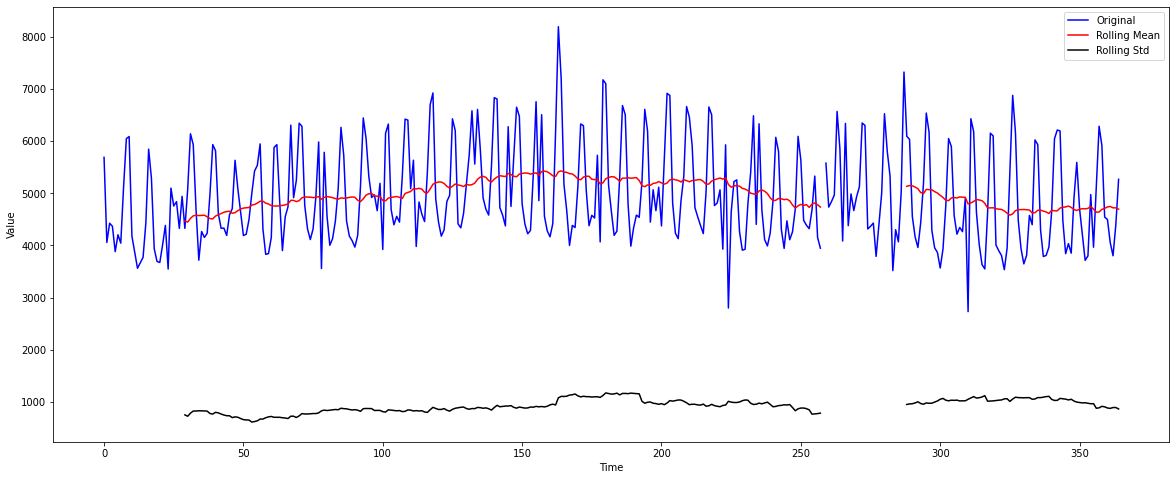

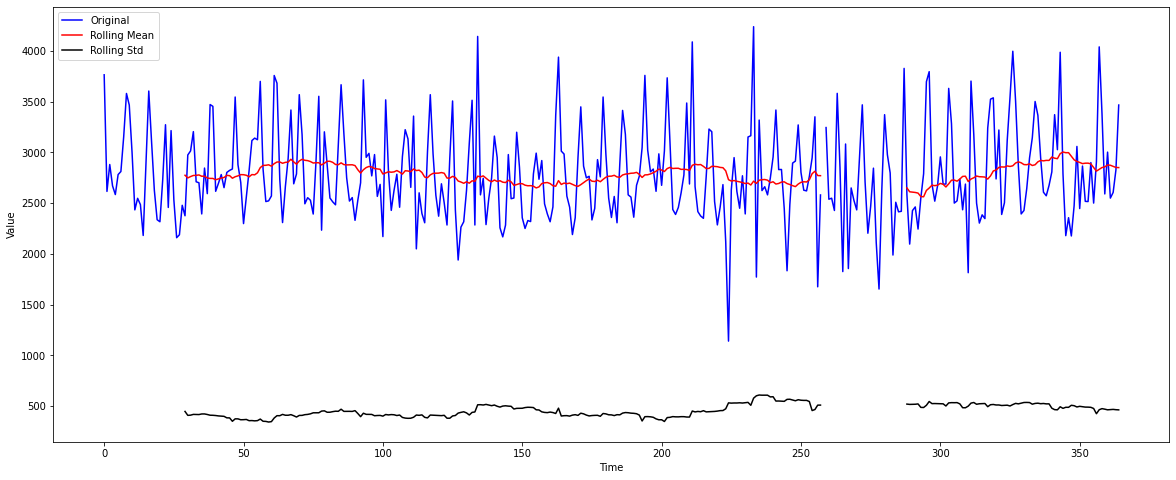

In [ ]:
def plot_timeseries_stat(timeseries):
    rollingMean = timeseries.rolling(window=30,center=False).mean()
    rollingStd = timeseries.rolling(window=30,center=False).std()
    plt.figure(figsize=(20,8))
    plt.xlabel("Time")
    plt.ylabel("Value")
    ori = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(rollingMean,color='red',label='Rolling Mean')
    std = plt.plot(rollingStd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)

plot_timeseries_stat(data['FOODS'])
plot_timeseries_stat(data['HOUSEHOLD'])
plot_timeseries_stat(data['HOBBIES'])

In [ ]:
#Analyzing time series is stationary or not
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math

def test_stationarityDF(timeseries): ##Dickey-Fuller Test
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','No of Observesations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Test Statistic               -4.68556
p-value                       0.00009
#Lags Used                   12.00000
No of Observesations Used   352.00000
Critical Value (1%)          -3.44906
Critical Value (5%)          -2.86979
Critical Value (10%)         -2.57116
dtype: float64


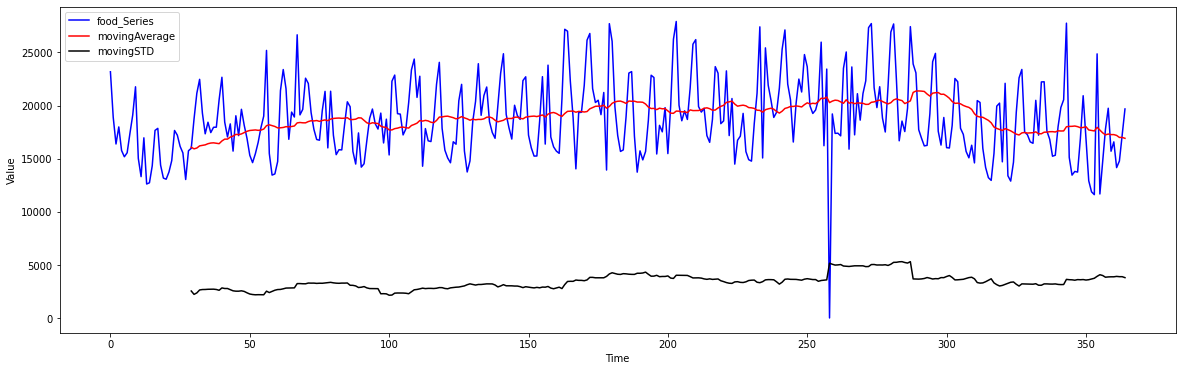

In [ ]:
#Time series for Foods Category
food_Series = data['FOODS']
food_Series.fillna(food_Series.mean(),inplace=True)
test_stationarityDF(food_Series)

movingAverage = food_Series.rolling(window=30).mean()
movingSTD = food_Series.rolling(window=30).std()

plt.figure(figsize=(20,6))
plt.xlabel("Time")
plt.ylabel("Value")
plt.plot(food_Series,color='blue',label='food_Series')
plt.plot(movingAverage,color='red',label='movingAverage')
plt.plot(movingSTD,color='black',label='movingSTD')
plt.legend(loc='best')
plt.show()

Test Statistic               -3.60341
p-value                       0.00570
#Lags Used                   15.00000
No of Observesations Used   349.00000
Critical Value (1%)          -3.44923
Critical Value (5%)          -2.86986
Critical Value (10%)         -2.57120
dtype: float64


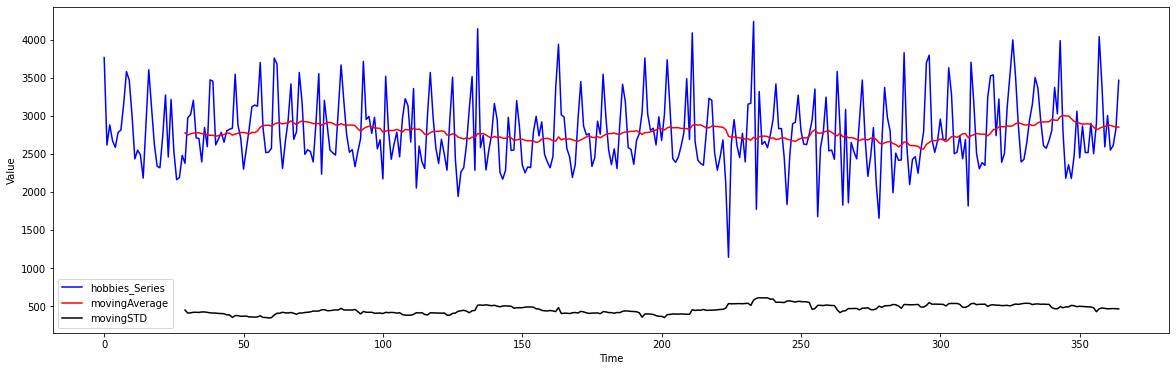

In [ ]:
#Time series for Hobiies Category
hobbies_Series = data['HOBBIES']
hobbies_Series.fillna(hobbies_Series.mean(),inplace=True)
test_stationarityDF(hobbies_Series)

movingAverage = hobbies_Series.rolling(window=30).mean()
movingSTD = hobbies_Series.rolling(window=30).std().round()
plt.figure(figsize=(20,6))
plt.xlabel("Time")
plt.ylabel("Value")
plt.plot(hobbies_Series,color='blue',label='hobbies_Series')
plt.plot(movingAverage,color='red',label='movingAverage')
plt.plot(movingSTD,color='black',label='movingSTD')
plt.legend(loc='best')
plt.show()

Test Statistic               -2.64014
p-value                       0.08498
#Lags Used                   15.00000
No of Observesations Used   349.00000
Critical Value (1%)          -3.44923
Critical Value (5%)          -2.86986
Critical Value (10%)         -2.57120
dtype: float64


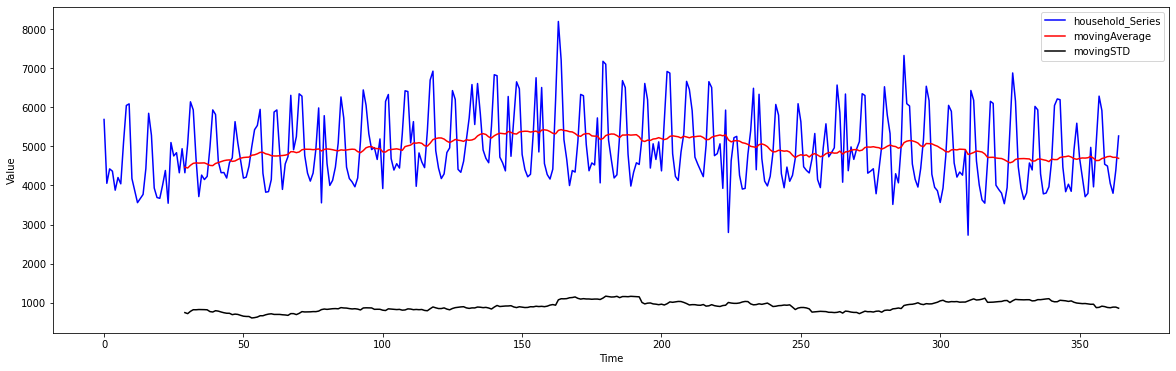

In [ ]:
#Time series for Household Category
household_Series = data['HOUSEHOLD']
household_Series.fillna(household_Series.mean(),inplace=True)
test_stationarityDF(household_Series)

movingAverage = household_Series.rolling(window=30).mean()
movingSTD = household_Series.rolling(window=30).std().round()
plt.figure(figsize=(20,6))
plt.xlabel("Time")
plt.ylabel("Value")
plt.plot(household_Series,color='blue',label='household_Series')
plt.plot(movingAverage,color='red',label='movingAverage')
plt.plot(movingSTD,color='black',label='movingSTD')
plt.legend(loc='best')
plt.show()

##We can observe that Test Statistic is not below the 1% of the Critical value. So, series is not stationary.

#ARIMA Model

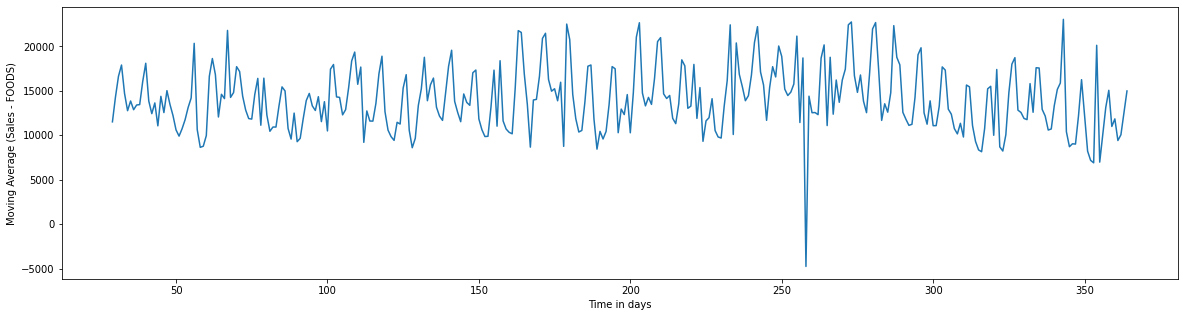

Test Statistic               -5.23
p-value                       0.00
#Lags Used                   12.00
No of Observesations Used   352.00
Critical Value (1%)          -3.45
Critical Value (5%)          -2.87
Critical Value (10%)         -2.57
dtype: float64


In [ ]:
#Making Food series stationary
foodSeriesDiff = food_Series-movingAverage
plt.figure(figsize=(20,5))
plt.xlabel("Time in days")
plt.ylabel("Moving Average (Sales - FOODS)")
plt.plot(foodSeriesDiff)
plt.show()
pd.set_option('display.float_format', '{:.2f}'.format)
foodSeriesDiff.fillna(foodSeriesDiff.mean(),inplace=True)
test_stationarityDF(foodSeriesDiff)

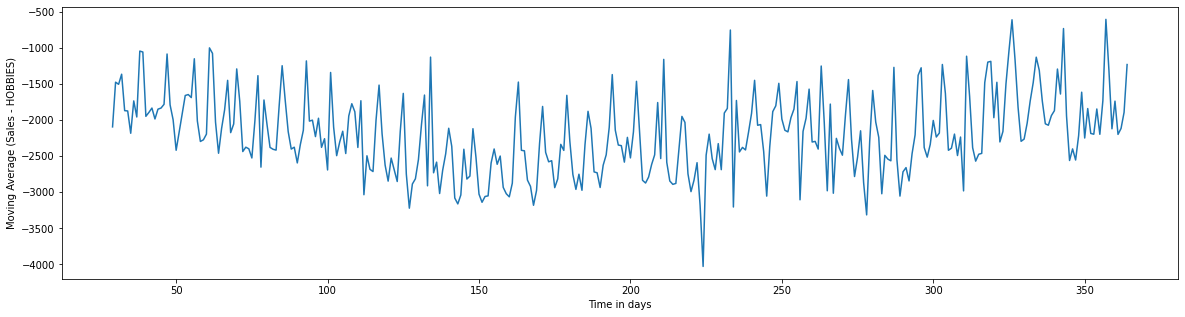

Test Statistic               -1.58474
p-value                       0.49126
#Lags Used                   15.00000
No of Observesations Used   349.00000
Critical Value (1%)          -3.44923
Critical Value (5%)          -2.86986
Critical Value (10%)         -2.57120
dtype: float64


In [ ]:
#Making Hobbies series stationary
hobbiesSeriesDiff = hobbies_Series-movingAverage
plt.figure(figsize=(20,5))
plt.xlabel("Time in days")
plt.ylabel("Moving Average (Sales - HOBBIES)")
plt.plot(hobbiesSeriesDiff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
hobbiesSeriesDiff.fillna(hobbiesSeriesDiff.mean(),inplace=True)
test_stationarityDF(hobbiesSeriesDiff)

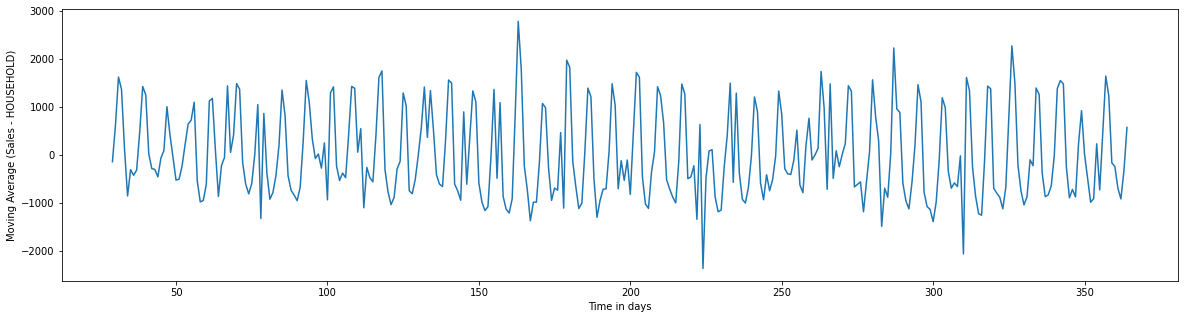

Test Statistic               -5.08624
p-value                       0.00001
#Lags Used                   13.00000
No of Observesations Used   351.00000
Critical Value (1%)          -3.44912
Critical Value (5%)          -2.86981
Critical Value (10%)         -2.57118
dtype: float64


In [ ]:
#Making Household series stationary
householdSeriesDiff = household_Series-movingAverage
plt.figure(figsize=(20,5))
plt.xlabel("Time in days")
plt.ylabel("Moving Average (Sales - HOUSEHOLD)")
plt.plot(householdSeriesDiff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
householdSeriesDiff.fillna(householdSeriesDiff.mean(),inplace=True)
test_stationarityDF(householdSeriesDiff)

##We can observe that Test Statistic is way less than 1% of critical value. So, we conculde that the above series for each category is 99% stationary.

##AUTOCORELATION FUNCTION for FOODS Category

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



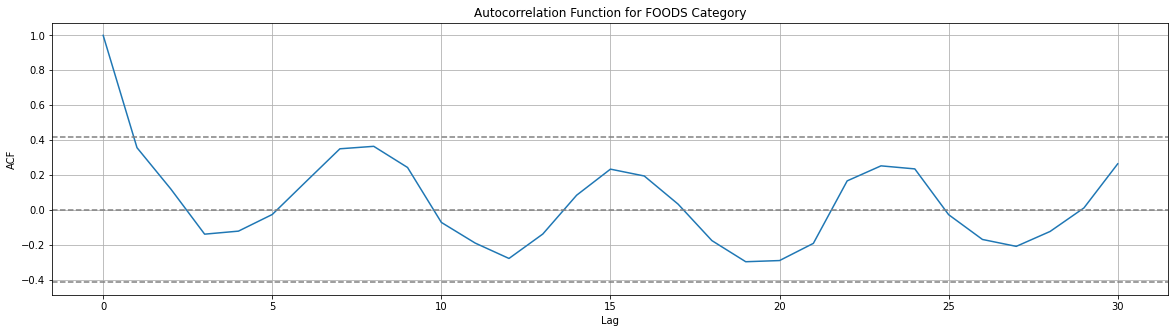

In [ ]:
plt.figure(figsize=(20,5))
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.plot(np.arange(0,31,1),acf(foodSeriesDiff,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function for FOODS Category')
plt.grid()
plt.show()

###Autocorrelation function cross upper confidence value between 1 and 2. Hence, we have taken p = 2 for ARIMA for FOODS Category.

##PARTIAL AUTOCORELATION FUNCTION for FOODS Category

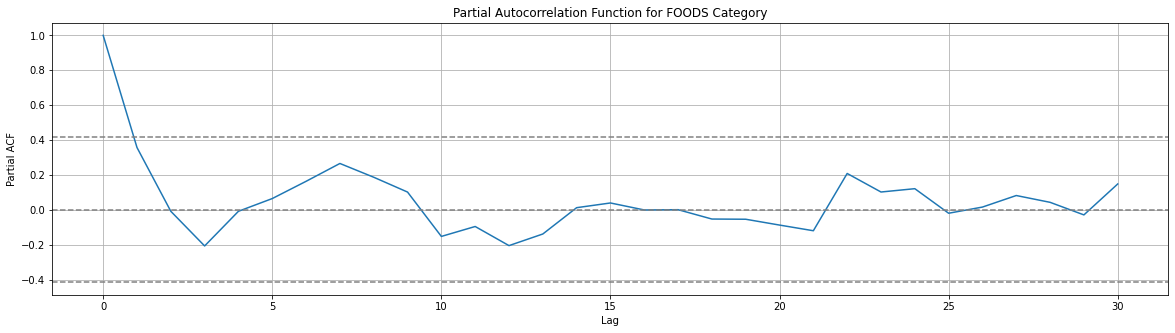

In [ ]:
plt.figure(figsize=(20,5))
plt.xlabel("Lag")
plt.ylabel("Partial ACF")
plt.plot(np.arange(0,31,1),pacf(foodSeriesDiff,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function for FOODS Category')
plt.grid()
plt.show()

###Partial Autocorrelation function drops to 0 when value is between 1 and 2. Hence we have taken q = 2 for ARIMA for FOODS Category.

##AUTOCORELATION FUNCTION for HOBBIES Category

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



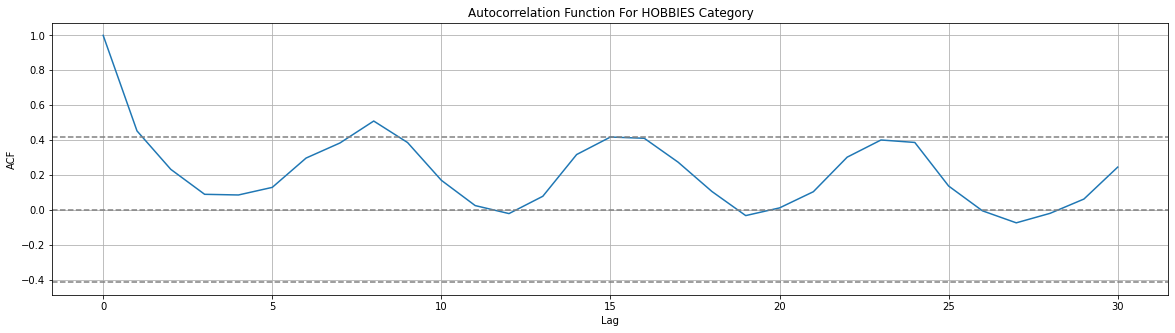

In [ ]:
plt.figure(figsize=(20,5))
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.plot(np.arange(0,31,1),acf(hobbiesSeriesDiff,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(hobbiesSeriesDiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(hobbiesSeriesDiff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function For HOBBIES Category')
plt.grid()
plt.show()

###Autcorrelation function cross upper confidence value between 1 and 2. Hence, we have taken p = 2 for ARIMA for HOBBIES Category.

##PARTIAL AUTOCORELATION FUNCTION for HOBBIES Category

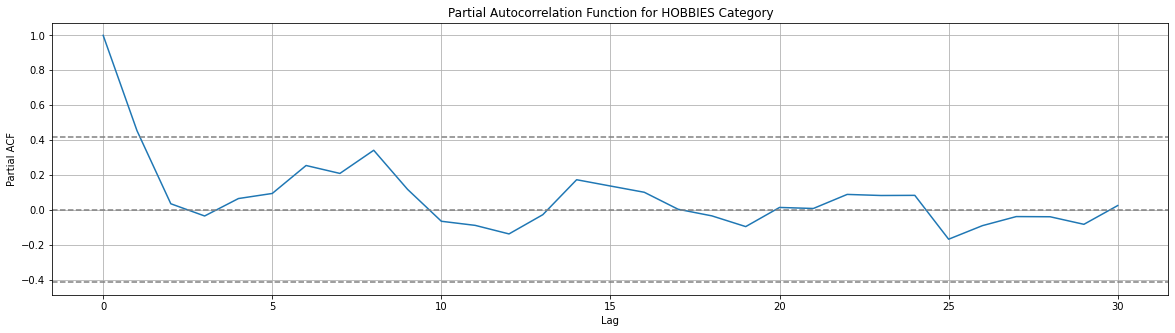

In [ ]:
plt.figure(figsize=(20,5))
plt.xlabel("Lag")
plt.ylabel("Partial ACF")
plt.plot(np.arange(0,31,1),pacf(hobbiesSeriesDiff,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(hobbiesSeriesDiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(hobbiesSeriesDiff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function for HOBBIES Category')
plt.grid()
plt.show()

###Partial Autocorrelation function drops to 0 when value is between 1 and 2. Hence we have taken q = 2 for ARIMA for HOBBIES Category.

##AUTOCORELATION FUNCTION for HOUSEHOLD Category

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



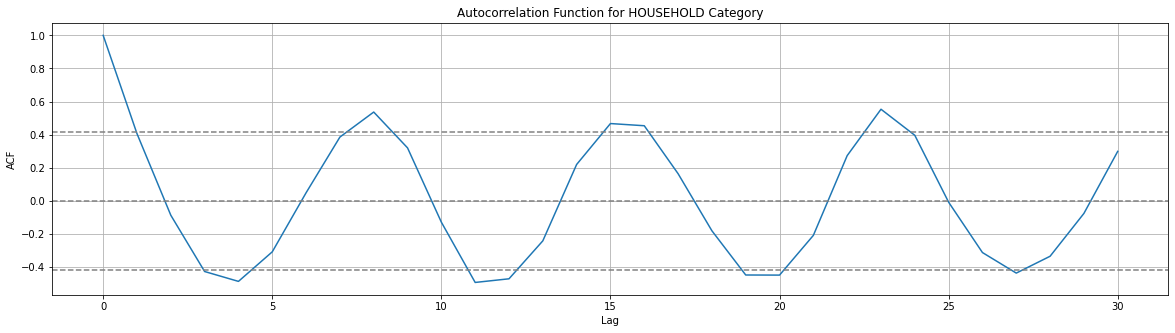

In [ ]:
plt.figure(figsize=(20,5))
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.plot(np.arange(0,31,1),acf(householdSeriesDiff,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(householdSeriesDiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(householdSeriesDiff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function for HOUSEHOLD Category')
plt.grid()
plt.show()

###Autocorrelation function cross upper confidence value between 1 and 2. Hence, we have taken p = 2 for ARIMA for HOUSEHOLD Category.

##PARTIAL AUTOCORELATION FUNCTION for HOUSEHOLD Category

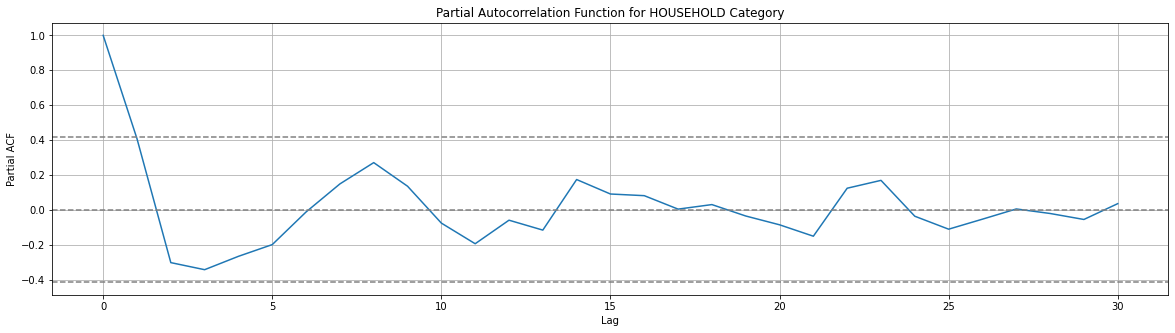

In [ ]:
plt.figure(figsize=(20,5))
plt.xlabel("Lag")
plt.ylabel("Partial ACF")
plt.plot(np.arange(0,31,1),pacf(householdSeriesDiff,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(householdSeriesDiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(householdSeriesDiff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function for HOUSEHOLD Category')
plt.grid()
plt.show()

###Partial Autocorrelation function drops to 0 when value is between 1 and 2. Hence we have taken q = 2 for ARIMA for HOUSEHOLD Category.

#ARIMA MODEL FOR FOODS CATEGORY

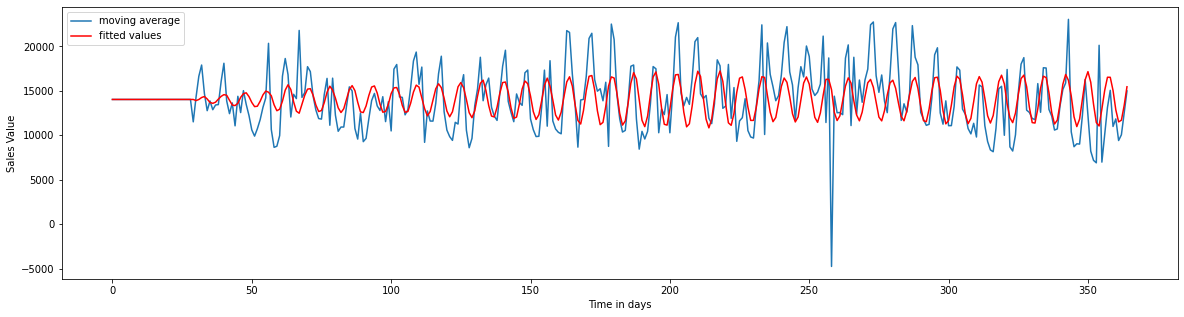

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model_foods = ARIMA(foodSeriesDiff,order=(2,0,2))
results_ARIMA_foods = model_foods.fit()
plt.figure(figsize=(20,5))
plt.xlabel("Time in days")
plt.ylabel("Sales Value")
plt.plot(foodSeriesDiff,label='moving average')
plt.plot(results_ARIMA_foods.fittedvalues, color='red',label='fitted values')
plt.legend(loc='best')
plt.show()

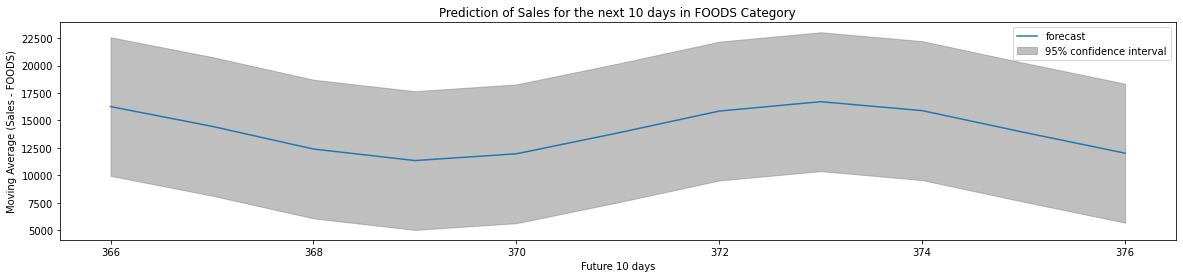

In [ ]:
f = plot_predict(results_ARIMA_foods,366, 376, dynamic=False)
f.set_figwidth(20)
f.set_figheight(4)
plt.xlabel("Future 10 days")
plt.ylabel("Moving Average (Sales - FOODS)")
plt.title("Prediction of Sales for the next 10 days in FOODS Category")
plt.show()

###RMSE Calculation of ARIMA for FOODS Category

In [ ]:
pred_foods = results_ARIMA_foods.get_prediction()
y_forecasted_foods = pred_foods.predicted_mean
y_truth_foods = foodSeriesDiff

In [ ]:
mse = ((y_forecasted_foods - y_truth_foods)**2).mean()
mse_foods = np.sqrt(mse)
rmse_foods = np.sqrt(mse_foods)

In [ ]:
print('The Root Mean Squared Error of our forecasts for FOODS Category is {:.2f}.'.format(rmse_foods))

The Root Mean Squared Error of our forecasts for FOODS Category is 54.76.


#ARIMA MODEL FOR HOBBIES CATEGORY

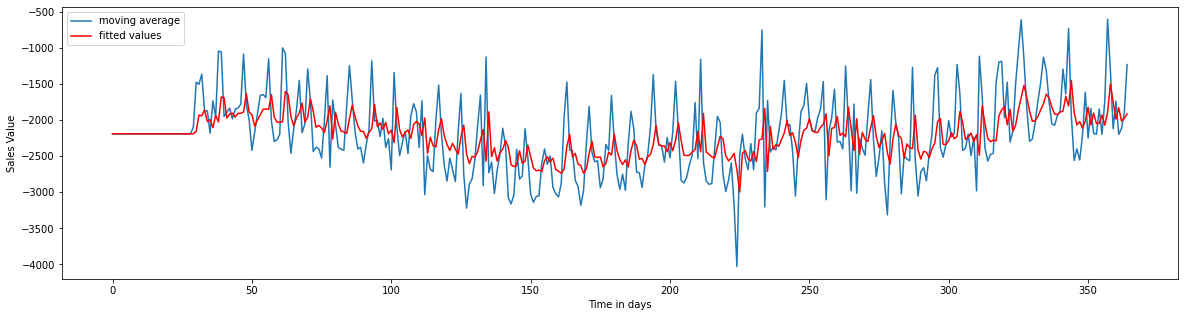

In [ ]:
model_hobbies = ARIMA(hobbiesSeriesDiff,order=(2,0,2))
results_ARIMA_hobbies = model_hobbies.fit()
plt.figure(figsize=(20,5))
plt.xlabel("Time in days")
plt.ylabel("Sales Value")
plt.plot(hobbiesSeriesDiff,label='moving average')
plt.plot(results_ARIMA_hobbies.fittedvalues, color='red',label='fitted values')
plt.legend(loc='best')
plt.show()

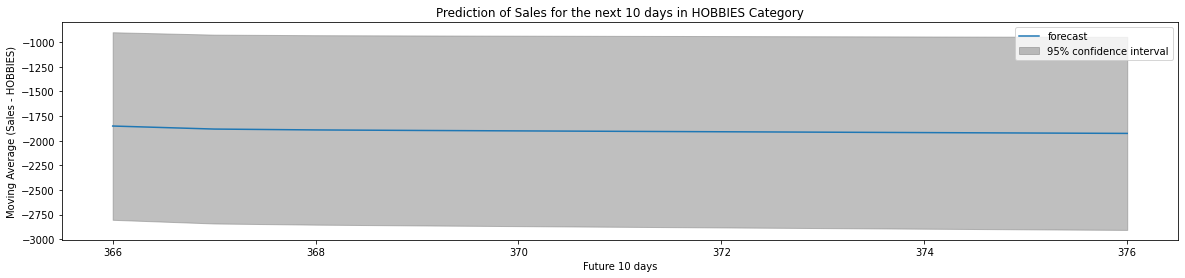

In [ ]:
f = plot_predict(results_ARIMA_hobbies,366, 376, dynamic=False)
f.set_figwidth(20)
f.set_figheight(4)
plt.xlabel("Future 10 days")
plt.ylabel("Moving Average (Sales - HOBBIES)")
plt.title("Prediction of Sales for the next 10 days in HOBBIES Category")
plt.show()

###RMSE Calculation of ARIMA for HOBBIES Category

In [ ]:
pred_hobbies = results_ARIMA_hobbies.get_prediction()
y_forecasted_hobbies = pred_hobbies.predicted_mean
y_truth_hobbies = hobbiesSeriesDiff

In [ ]:
mse = ((y_forecasted_hobbies - y_truth_hobbies)**2).mean()
mse_hobbies = np.sqrt(mse)
rmse_hobbies = np.sqrt(mse_hobbies)

In [ ]:
print('The Root Mean Squared Error of our forecasts for HOBBIES Category is {:.2f}.'.format(rmse_hobbies))

The Root Mean Squared Error of our forecasts for HOBBIES Category is 21.38.


#ARIMA MODEL FOR HOUSEHOLD CATEGORY

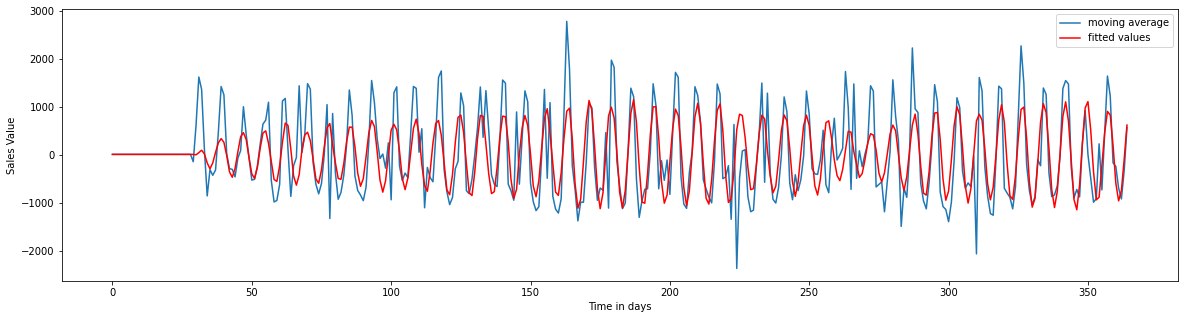

In [ ]:
model_household = ARIMA(householdSeriesDiff,order=(2,0,2))
results_ARIMA_household = model_household.fit()
plt.figure(figsize=(20,5))
plt.xlabel("Time in days")
plt.ylabel("Sales Value")
plt.plot(householdSeriesDiff,label='moving average')
plt.plot(results_ARIMA_household.fittedvalues, color='red',label='fitted values')
plt.legend(loc='best')
plt.show()

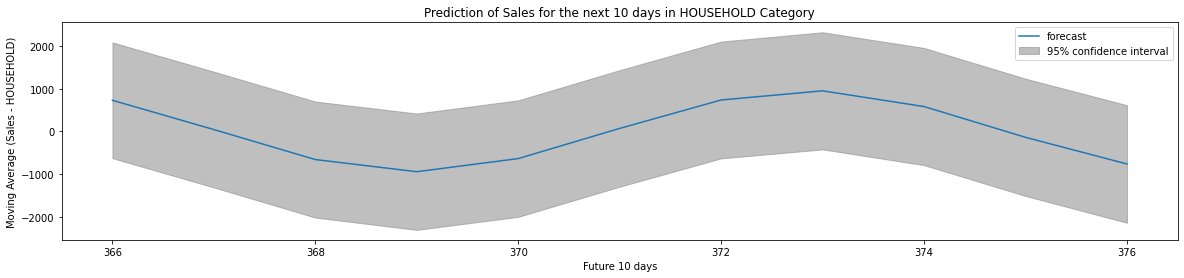

In [ ]:
f = plot_predict(results_ARIMA_household,366, 376, dynamic=False)
f.set_figwidth(20)
f.set_figheight(4)
plt.xlabel("Future 10 days")
plt.ylabel("Moving Average (Sales - HOUSEHOLD)")
plt.title("Prediction of Sales for the next 10 days in HOUSEHOLD Category")
plt.show()

###RMSE Calculation of ARIMA for HOUSEHOLD Category

In [ ]:
pred_household = results_ARIMA_household.get_prediction()
y_forecasted_household = pred_household.predicted_mean
y_truth_household = householdSeriesDiff

In [ ]:
mse = ((y_forecasted_household - y_truth_household)**2).mean()
mse_household = np.sqrt(mse)
rmse_household = np.sqrt(mse_household)

In [ ]:
print('The Root Mean Squared Error of our forecasts for HOUSEHOLD Category is {:.2f}.'.format(rmse_household))

The Root Mean Squared Error of our forecasts for HOUSEHOLD Category is 25.03.


##Observation: It can be clearly seen through the graphs and the results that the ARIMA model did not really do well for our data for each category. Hence, we further implemented LSTM model.

#LSTM Model Implementation

In [ ]:
data.columns

Index(['d', 'date', 'weekday', 'month', 'event_name_1', 'event_type_1',
       'snap_CA', 'snap_TX', 'snap_WI', 'NAME', 'WT01', 'WT03', 'WT04', 'WT05',
       'WT06', 'WT11', 'Med_Income', 'FOODS', 'HOBBIES', 'HOUSEHOLD'],
      dtype='object')

In [ ]:
new_data = data.copy()

In [ ]:
new_data.head()

,d,date,weekday,month,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,NAME,WT01,WT03,WT04,WT05,WT06,WT11,Med_Income,FOODS,HOBBIES,HOUSEHOLD
0,d_1,2011-01-29,Saturday,1,no_event,no_event,0,0,0,"WATERTOWN WWTP, WI US",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,51205,23178.00000,3764.00000,5689.00000
1,d_10,2011-02-07,Monday,2,no_event,no_event,1,1,0,"WATERTOWN WWTP, WI US",0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,51205,18901.00000,2615.00000,4056.00000
2,d_100,2011-05-08,Sunday,5,Mother's day,Cultural,1,0,1,"WATERTOWN WWTP, WI US",0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,51205,16383.00000,2880.00000,4425.00000
3,d_101,2011-05-09,Monday,5,no_event,no_event,1,1,1,"WATERTOWN WWTP, WI US",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,51205,17988.00000,2670.00000,4366.00000
4,d_102,2011-05-10,Tuesday,5,no_event,no_event,1,0,0,"WATERTOWN WWTP, WI US",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,51205,15767.00000,2584.00000,3880.00000


In [ ]:
new_data = new_data.drop('date', axis=1)

In [ ]:
le = preprocessing.LabelEncoder()
for column_name in new_data.columns:
    if new_data[column_name].dtype == object:
        new_data[column_name] = le.fit_transform(new_data[column_name])
    else:
        pass

In [ ]:
#Feature Scaling: Scale features using min-max scaler in range 0-1
sc = MinMaxScaler(feature_range = (0, 1))
scaled_data = sc.fit_transform(new_data)

In [ ]:
timesteps = 10  # use the last 28 days to predict the next day's sales
X_train = []
y_train = []

for i in range(timesteps, 365):
    X_train.append(scaled_data[i-timesteps:i])
    y_train.append(scaled_data[i][0:19])

In [ ]:
#Convert to np array to be able to feed the LSTM model
X_train = np.array(X_train, dtype = 'float16')
y_train = np.array(y_train, dtype = 'float16')
print(X_train.shape)
print(y_train.shape)

(355, 10, 19)
(355, 19)


In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units =64,input_shape = (np.array(X_train).shape[1], np.array(X_train).shape[2])))
model.add(tf.keras.layers.Dense(19))

model.compile(
  loss='mean_squared_error',
  optimizer=tf.keras.optimizers.Adam(0.001)
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                21504     
                                                                 
 dense_1 (Dense)             (None, 19)                1235      
                                                                 
Total params: 22,739
Trainable params: 22,739
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs = 10, batch_size = 10)

Epoch 1/10
36/36 [==============================] - 2s 3ms/step - loss: 0.1573
Epoch 2/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0989
Epoch 3/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0939
Epoch 4/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0911
Epoch 5/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0882
Epoch 6/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0864
Epoch 7/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0849
Epoch 8/10
36/36 [==============================] - 0s 4ms/step - loss: 0.0833
Epoch 9/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0828
Epoch 10/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0827


In [ ]:
inputs = scaled_data[-timesteps:]
inputs = sc.transform(inputs)
input = inputs.copy()

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [ ]:
X_test = []
X_test.append(input[0:timesteps])
X_test = np.array(X_test)

In [ ]:
pred = []
for i in range(0, 10):
  inputs = scaled_data[-10-i:]
  inputs = sc.transform(inputs)
  X_test = []
  X_test.append(inputs[0:timesteps])
  X_test = np.array(X_test)
  predictions = model.predict(X_test)
  pred = np.append(pred, predictions[-1][-1])

for i in range(0,10):
  if(pred[i] < 0):
    pred[i] = pred[i]*(-1)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 16ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 15ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



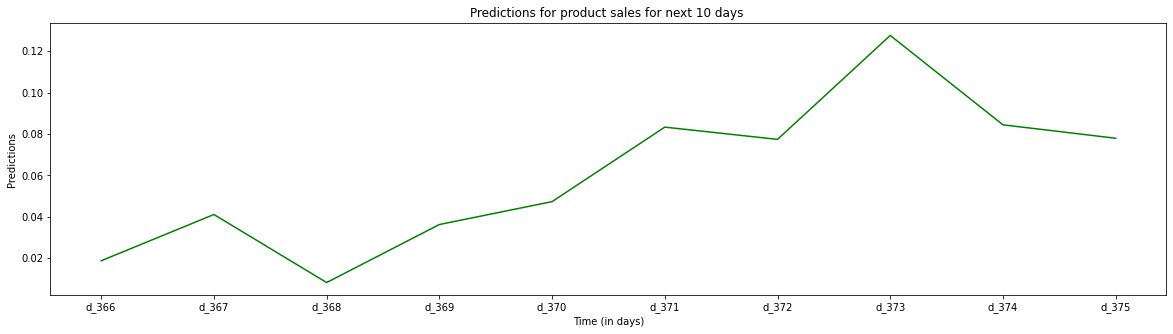

In [ ]:
x = ['d_366', 'd_367', 'd_368', 'd_369', 'd_370', 'd_371', 'd_372', 'd_373', 'd_374', 'd_375']
y = pred
plt.figure(figsize=(20,5))
plt.title("Predictions for product sales for next 10 days ")
plt.xlabel("Time (in days)")
plt.ylabel("Predictions")
plt.plot(x, y, color ="green")

plt.show()

In [ ]:
X = X_test[-1][-1][0:10]
mse_lstm = mean_squared_error(X, pred)
score = math.sqrt(mean_squared_error(X, pred))
print("RMSE score for LSTM model: %.2f" % score)

RMSE score for LSTM model: 0.16


#Performance Metrics for ARIMA & LSTM Models

In [ ]:
table = [['', 'Prediction Category', 'MSE Score','RMSE Score'], 
         ['', 'Food Category', '{:.2f}'.format(mse_foods),'{:.2f}'.format(rmse_foods)], 
         ['ARIMA Model', 'Hobbies Category', '{:.2f}'.format(mse_hobbies),'{:.2f}'.format(rmse_hobbies)], 
         ['', 'Household Category', '{:.2f}'.format(mse_household),'{:.2f}'.format(rmse_household)],
         ['LSTM Model', 'Total Sales', '{:.2f}'.format(mse_lstm),'{:.2f}'.format(score)]]
print(tabulate(table, headers='firstrow'))

             Prediction Category      MSE Score    RMSE Score
-----------  ---------------------  -----------  ------------
             Food Category              2999.07         54.76
ARIMA Model  Hobbies Category            456.9          21.38
             Household Category          626.73         25.03
LSTM Model   Total Sales                   0.03          0.16
